# Financial Reasoning Agent with GRPO Fine-Tuning

This notebook implements a **Financial Analyst Agent** capable of complex reasoning and accurate calculation. We leverage a **"Thinking" Model** (DeepSeek-R1-Distill-Qwen-7B) fine-tuned with **Unsloth & GRPO**, orchestrate it via **LangGraph**, and empower it with a **Python REPL Tool** for precise arithmetic.

## Architecture Overview

```
┌─────────────────────────────────────────────────────────────────┐
│                    Financial Reasoning Agent                    │
├─────────────────────────────────────────────────────────────────┤
│  ┌──────────┐    ┌──────────┐    ┌──────────┐    ┌───────────┐  │
│  │  Think   │ -> │ Generate │ -> │ Execute  │ -> │ Finalize  │  │
│  │  Node    │    │  Code    │    │  Python  │    │  Answer   │  │
│  └──────────┘    └──────────┘    └──────────┘    └───────────┘  │
│        │               │               │               │        │
│        v               v               v               v        │
│   <think>...</think>  ```python   REPL Output    <answer>       │
│   Reasoning trace    calculation   Precise math   Final result  │
└─────────────────────────────────────────────────────────────────┘
```

## Key Features

- **"Thinking" Architecture**: The model generates explicit reasoning traces (`<think>...</think>`) before answering
- **Tool-Augmented Reasoning**: Python REPL executes math derived during thinking phase for 100% arithmetic accuracy
- **Before/After Comparison**: We evaluate agent performance with Base Model vs. Fine-Tuned Model
- **Full Observability**: All traces and experiments logged to **MLflow** with LLM-as-Judge evaluation

## Tech Stack

| Component | Library | Purpose |
|-----------|---------|--------|
| Model Tuning | `unsloth`, `trl` (GRPO), `peft` | Efficient fine-tuning with reinforcement learning |
| Orchestration | `langchain`, `langgraph` | Agent workflow and state management |
| Tools | `langchain_experimental` | Python REPL for precise calculations |
| Data Processing | `polars`, `datasets` | Fast DataFrame operations |
| Evaluation | `mlflow`, `google-genai` | Experiment tracking & LLM-as-Judge |
| Hardware | DGX Spark / GB10 GPU / CUDA | GPU acceleration |

---

## Table of Contents

1. [Phase 1: Environment & Data Preparation](#phase-1-environment--data-preparation)
2. [Phase 2: Agent Definition](#phase-2-agent-definition)  
3. [Phase 3: Base Model Evaluation](#phase-3-base-model-evaluation)
4. [Phase 4: GRPO Fine-Tuning](#phase-4-grpo-fine-tuning)
5. [Phase 5: Tuned Model Evaluation & Comparison](#phase-5-tuned-model-evaluation--comparison)


# Phase 1: Environment & Data Preparation

## Functional Design

This phase establishes the foundation for the entire project:
- Load environment variables (API keys, tokens)
- Initialize MLflow experiment tracking with proper configuration
- Load and preprocess the ConvFinQA dataset for financial reasoning tasks
- Define the prompt structure that teaches the model our "thinking" paradigm

## Technical Design

**Why ConvFinQA?**
- Contains complex financial questions requiring **multi-step mathematical reasoning**
- Provides rich context from financial documents (10-K reports, earnings calls)
- Ground truth answers enable supervised and RL-based training

**Data Enhancement Strategy:**
We format data to reward the model for:
1. Generating clear reasoning in `<think>` tags
2. Producing executable Python code for calculations
3. Outputting final answers in `<answer>` tags


## 1.1 Setup & Dependencies

Before running this notebook, ensure:
1. **GPU**: NVIDIA GPU with CUDA support (tested on DGX Spark / GB10)
2. **Environment variables**: `.env` file with `HF_TOKEN` and `GEMINI_API_KEY`
3. **MLflow Server**: Start before running: `mlflow ui --port 5000`
4. **Devcontainer**: Use the provided devcontainer which includes `litellm` (required by MLflow's `make_judge` for Gemini)


In [1]:
# ============================================================================
# IMPORTS & CONFIGURATION
# ============================================================================
import os
import sys
import re
import warnings
from pathlib import Path
from typing import TypedDict, Annotated, List, Optional, Callable
from dataclasses import dataclass
import operator

import polars as pl
import pandas as pd
from datasets import load_dataset, Dataset
from dotenv import load_dotenv

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# ============================================================================
# PROJECT PATHS (relative to project root)
# ============================================================================
PROJECT_ROOT = Path().absolute().parent.parent
NOTEBOOKS_DIR = PROJECT_ROOT / "notebooks" / "agents"
DATA_DIR = PROJECT_ROOT / "data"
MODELS_DIR = PROJECT_ROOT / "models"
MLRUNS_DIR = NOTEBOOKS_DIR / "mlruns"

# ============================================================================
# LOAD ENVIRONMENT VARIABLES
# ============================================================================
env_path = PROJECT_ROOT / ".env"
if env_path.exists():
    load_dotenv(env_path)
    print(f"✓ Loaded .env from: {env_path}")
else:
    load_dotenv()
    print("✓ Loaded .env from current directory")

# ============================================================================
# CONFIGURATION PARAMETERS
# ============================================================================
@dataclass
class Config:
    """Central configuration for the Financial Reasoning Agent project."""
    
    # API Keys
    HF_TOKEN: str = os.getenv("HF_TOKEN", "")
    GEMINI_API_KEY: str = os.getenv("GEMINI_API_KEY", "")
    GEMINI_MODEL: str = "gemini-2.5-pro"  # Model for LLM-as-Judge evaluation
    
    # Model Configuration
    MODEL_NAME: str = "unsloth/DeepSeek-R1-Distill-Qwen-7B"  # DeepSeek R1 distilled - excellent reasoning
    MAX_SEQ_LENGTH: int = 8192
    LOAD_IN_4BIT: bool = True
    GPU_MEMORY_UTILIZATION: float = 0.85
    
    # Training Configuration  
    LEARNING_RATE: float = 5e-6
    BATCH_SIZE: int = 1
    GRADIENT_ACCUMULATION_STEPS: int = 4
    MAX_TRAINING_STEPS: int = 1000  # Increased from 300 for better convergence
    LOGGING_STEPS: int = 10
    
    # Evaluation Configuration
    EVALUATION_SAMPLES: int = 20  # Increased for more robust evaluation
    MAX_NEW_TOKENS: int = 2048  # Increased to allow longer reasoning traces
    RANDOM_SEED: int = 42  # Seed for reproducible random sampling
    
    # MLflow Configuration
    MLFLOW_EXPERIMENT_NAME: str = "Financial-Reasoning-Agent"
    MLFLOW_TRACKING_URI: str = f"file://{MLRUNS_DIR}"
    
    # Output Paths
    OUTPUT_DIR: str = str(MODELS_DIR / "checkpoints" / "deepseek-r1-fin-agent")

config = Config()

# Validate configuration
print("\n" + "="*60)
print("CONFIGURATION")
print("="*60)
print(f"  Model: {config.MODEL_NAME}")
print(f"  Max Seq Length: {config.MAX_SEQ_LENGTH}")
print(f"  4-bit Quantization: {config.LOAD_IN_4BIT}")
print(f"  GPU Memory Utilization: {config.GPU_MEMORY_UTILIZATION}")
print(f"  Training Steps: {config.MAX_TRAINING_STEPS}")
print(f"  Evaluation Samples: {config.EVALUATION_SAMPLES}")
print(f"  Random Seed: {config.RANDOM_SEED}")
print(f"  HF Token: {'✓ Set' if config.HF_TOKEN else '✗ Not set'}")
print(f"  Gemini API Key: {'✓ Set' if config.GEMINI_API_KEY else '✗ Not set'}")
print(f"  Gemini Model: {config.GEMINI_MODEL}")
print("="*60)


✓ Loaded .env from: /workspace/.env

CONFIGURATION
  Model: unsloth/DeepSeek-R1-Distill-Qwen-7B
  Max Seq Length: 8192
  4-bit Quantization: True
  GPU Memory Utilization: 0.85
  Training Steps: 1000
  Evaluation Samples: 20
  Random Seed: 42
  HF Token: ✓ Set
  Gemini API Key: ✓ Set
  Gemini Model: gemini-2.5-pro


## 1.2 MLflow Initialization

**Technical Notes:**
- We configure MLflow to store all experiment data locally in the `mlruns/` directory
- `mlflow.langchain.autolog()` captures LangGraph agent traces automatically
- Each run will log: parameters, metrics, artifacts, and full agent trajectories
- The LLM-as-Judge evaluations will appear in the MLflow UI under the "Evaluation" tab


In [2]:
# ============================================================================
# MLFLOW INITIALIZATION
# ============================================================================
import mlflow
from mlflow.tracking import MlflowClient

# Create mlruns directory if it doesn't exist
MLRUNS_DIR.mkdir(parents=True, exist_ok=True)

# Set tracking URI and experiment
mlflow.set_tracking_uri(config.MLFLOW_TRACKING_URI)
mlflow.set_experiment(config.MLFLOW_EXPERIMENT_NAME)

# Enable autologging for LangChain/LangGraph
# This captures agent traces, LLM calls, and tool invocations
# Note: mlflow.langchain.autolog() takes no parameters in current versions
try:
    mlflow.langchain.autolog()
    print("✓ LangChain autologging enabled")
except Exception as e:
    print(f"⚠ LangChain autologging not available: {e}")
    print("  MLflow will still track runs and metrics, but without automatic LLM tracing.")

# Get experiment info
client = MlflowClient()
experiment = client.get_experiment_by_name(config.MLFLOW_EXPERIMENT_NAME)

print("\n✓ MLflow initialized")
print(f"  Tracking URI: {config.MLFLOW_TRACKING_URI}")
print(f"  Experiment: {config.MLFLOW_EXPERIMENT_NAME}")
print(f"  Experiment ID: {experiment.experiment_id if experiment else 'New'}")
print(f"  View traces at: http://localhost:5000")


⚠ LangChain autologging not available: No module named 'langchain'
  MLflow will still track runs and metrics, but without automatic LLM tracing.

✓ MLflow initialized
  Tracking URI: file:///workspace/notebooks/agents/mlruns
  Experiment: Financial-Reasoning-Agent
  Experiment ID: 425390645702784385
  View traces at: http://localhost:5000


## 1.3 Load & Explore ConvFinQA Dataset

**Dataset: [ConvFinQA](https://huggingface.co/datasets/MehdiHosseiniMoghadam/ConvFinQA)**

ConvFinQA (Conversational Finance Question Answering) contains:
- Financial context from real SEC filings and earnings reports
- Multi-turn conversational questions requiring numerical reasoning
- **Ground truth answers WITH explicit calculation steps** (key improvement!)

**Why this dataset version (MehdiHosseiniMoghadam)?**
- Contains **`steps` column** with explicit reasoning traces for each answer
- Each step has: operation, arguments, and intermediate results
- Enables **Process Reward Model (PRM)** training with step-level feedback
- Provides **`pre_text`, `post_text`, and `table`** for structured context

**Data Enhancement Strategy:**
We use the `steps` column to generate synthetic `<think>` traces, giving the model explicit reasoning examples to learn from during GRPO training.


In [5]:
# ============================================================================
# LOAD CONVFINQA DATASET (MehdiHosseiniMoghadam version with steps)
# ============================================================================
print("Loading ConvFinQA dataset from HuggingFace (MehdiHosseiniMoghadam version)...")

# Load the dataset - this version has the crucial 'steps' column for reasoning traces
dataset = load_dataset("MehdiHosseiniMoghadam/ConvFinQA", split="train")

# Convert to Polars for fast data manipulation
df = pl.from_pandas(dataset.to_pandas())

print(f"\n✓ Dataset loaded successfully")
print(f"  Total samples: {len(df):,}")
print(f"  Columns: {df.columns}")
print(f"  Memory usage: {df.estimated_size() / 1e6:.2f} MB")

# Highlight the key columns for GRPO training
print(f"\n📊 Key columns for reasoning:")
print(f"  - pre_text: Context before table")
print(f"  - post_text: Context after table")
print(f"  - table: Structured financial data")
print(f"  - question: The financial question")
print(f"  - answer: Ground truth answer")
print(f"  - steps: REASONING STEPS (crucial for PRM training!)")


Loading ConvFinQA dataset from HuggingFace (MehdiHosseiniMoghadam version)...


Repo card metadata block was not found. Setting CardData to empty.



✓ Dataset loaded successfully
  Total samples: 3,037
  Columns: ['pre_text', 'post_text', 'filename', 'table_ori', 'table', 'question', 'answer', 'steps', 'id']
  Memory usage: 13.49 MB

📊 Key columns for reasoning:
  - pre_text: Context before table
  - post_text: Context after table
  - table: Structured financial data
  - question: The financial question
  - answer: Ground truth answer
  - steps: REASONING STEPS (crucial for PRM training!)


In [6]:
# ============================================================================
# EXPLORE SAMPLE DATA
# ============================================================================
# Display a sample to understand the data structure
sample = df.head(3).to_pandas()

print("="*80)
print("SAMPLE DATA EXPLORATION")
print("="*80)

for idx, row in sample.iterrows():
    print(f"\n{'='*80}")
    print(f"--- Sample {idx + 1} ---")
    print(f"{'='*80}")
    
    # Show pre_text (context before table)
    # Note: HuggingFace datasets may store lists as numpy arrays
    pre_text = row.get('pre_text', [])
    if pre_text is not None and len(pre_text) > 0:
        pre_text_list = list(pre_text) if hasattr(pre_text, '__iter__') and not isinstance(pre_text, str) else [str(pre_text)]
        pre_text_str = ' '.join(str(item) for item in pre_text_list)
        print(f"\n📄 Pre-text (first 300 chars):\n{pre_text_str[:300]}...")
    
    # Show table structure
    table = row.get('table', [])
    if table is not None and len(table) > 0:
        table_list = list(table) if hasattr(table, '__iter__') and not isinstance(table, str) else []
        print(f"\n📊 Table (first 3 rows):")
        for i, trow in enumerate(table_list[:3]):
            print(f"  {list(trow) if hasattr(trow, '__iter__') else trow}")
        if len(table_list) > 3:
            print(f"  ... ({len(table_list) - 3} more rows)")
    
    # Show question and answer
    print(f"\n❓ Question: {row.get('question', 'N/A')}")
    print(f"\n✅ Answer: {row.get('answer', 'N/A')}")
    
    # Show reasoning steps (THE KEY FEATURE!)
    steps = row.get('steps', [])
    if steps is not None and len(steps) > 0:
        steps_list = list(steps) if hasattr(steps, '__iter__') and not isinstance(steps, (str, dict)) else []
        print(f"\n🧠 Reasoning Steps ({len(steps_list)} steps):")
        for i, step in enumerate(steps_list[:5]):  # Show first 5 steps
            if isinstance(step, dict):
                print(f"  Step {i+1}: {step.get('op', '?')}({step.get('arg1', '?')}, {step.get('arg2', '?')}) = {step.get('res', '?')}")
            else:
                print(f"  Step {i+1}: {step}")
        if len(steps_list) > 5:
            print(f"  ... ({len(steps_list) - 5} more steps)")
    else:
        print(f"\n🧠 Reasoning Steps: (none)")
    
    print("-"*80)


SAMPLE DATA EXPLORATION

--- Sample 1 ---

📄 Pre-text (first 300 chars):
26 | 2009 annual report in fiscal 2008 , revenues in the credit union systems and services business segment increased 14% ( 14 % ) from fiscal 2007 . all revenue components within the segment experienced growth during fiscal 2008 . license revenue generated the largest dollar growth in revenue as ep...

📊 Table (first 3 rows):
  ['2008', 'year ended june 30 2009 2008', 'year ended june 30 2009 2008', 'year ended june 30 2009']
  ['net income', '$ 103102', '$ 104222', '$ 104681']
  ['non-cash expenses', '74397', '70420', '56348']
  ... (4 more rows)

❓ Question: what was the percentage change in the net cash from operating activities from 2008 to 2009

✅ Answer: 14.1%

🧠 Reasoning Steps (2 steps):
  Step 1: minus2-1(206588, 181001) = 25587
  Step 2: divide2-2(#0, 181001) = 14.1%
--------------------------------------------------------------------------------

--- Sample 2 ---

📄 Pre-text (first 300 chars):
substant

## 1.4 Format Data for GRPO Training

**GRPO (Group Relative Policy Optimization)** requires data in a specific format:
- `prompt`: The input to the model (system + user message)
- `answer`: The ground truth for reward calculation

**Our Prompt Engineering Strategy:**

We instruct the model to follow a 3-step process:
1. **Think**: Output reasoning in `<think>` tags
2. **Calculate**: Generate Python code if math is needed  
3. **Answer**: Output final answer in `<answer>` tags

This structure enables:
- Clear separation of reasoning from final answer
- Tool integration (Python REPL) for arithmetic
- Reward signals at each stage during GRPO training


In [7]:
# ============================================================================
# DEFINE SYSTEM PROMPT & DATA FORMATTING
# ============================================================================

# The system prompt that defines our "Thinking" architecture
# Optimized for DeepSeek-R1-Distill which naturally produces reasoning traces
SYSTEM_PROMPT = """You are an expert financial analyst with deep expertise in numerical reasoning.

Your task is to answer financial questions accurately. Follow this process:

1. **THINK**: First, reason through the problem step-by-step in <think> tags.
   - Identify the relevant numbers from the context and tables
   - State clearly what calculation is needed and why
   - Show each step of your reasoning with intermediate results
   - Example: "From the table, revenue in 2022 was $1.5M and in 2023 was $1.8M"

2. **CALCULATE**: If calculation is needed, generate Python code in a code block.
   - Use only basic Python (no imports needed beyond math)
   - Store the final result in a variable called `result`
   - The code will be executed to get the precise answer

3. **ANSWER**: Output your final answer in <answer> tags.
   - Be concise and precise
   - Include units if applicable (%, $, millions, etc.)
   - For percentages, output as decimal (e.g., 0.25) or percentage (e.g., 25%)

Example:
<think>
The question asks for the percentage change in revenue from 2022 to 2023.
From the context: 2022 revenue = $1,500,000, 2023 revenue = $1,800,000
Formula: ((new - old) / old) * 100
Step 1: Difference = 1,800,000 - 1,500,000 = 300,000
Step 2: Percentage = (300,000 / 1,500,000) * 100 = 20%
</think>

```python
old_value = 1500000
new_value = 1800000
result = ((new_value - old_value) / old_value) * 100
print(f"{result}%")
```

<answer>20%</answer>"""


# ============================================================================
# ANSWER NORMALIZATION UTILITIES
# ============================================================================

def normalize_answer(answer: str) -> tuple[float, str]:
    """
    Normalize an answer string to a numeric value and detect its format.
    
    Returns:
        tuple of (numeric_value, format_type) where format_type is 'percent', 'decimal', or 'number'
    """
    if not answer:
        return None, 'unknown'
    
    answer_str = str(answer).strip().lower()
    
    # Remove common formatting
    answer_str = answer_str.replace(',', '').replace('$', '').replace(' ', '')
    
    # Detect percentage
    is_percent = '%' in answer_str
    answer_str = answer_str.replace('%', '')
    
    try:
        value = float(answer_str)
        if is_percent:
            return value / 100, 'percent'  # Convert to decimal for comparison
        elif abs(value) < 1 and '.' in str(answer):
            return value, 'decimal'  # Already a decimal like 0.25
        else:
            return value, 'number'
    except ValueError:
        return None, 'unknown'

def answers_match(pred: str, gold: str, tolerance: float = 0.02) -> bool:
    """
    Check if two answers match, handling different formats.
    
    Args:
        pred: Predicted answer
        gold: Ground truth answer
        tolerance: Relative tolerance for numeric comparison (default 2%)
    
    Returns:
        True if answers match within tolerance
    """
    pred_val, pred_fmt = normalize_answer(pred)
    gold_val, gold_fmt = normalize_answer(gold)
    
    if pred_val is None or gold_val is None:
        # Fall back to string comparison
        return str(pred).strip().lower() == str(gold).strip().lower()
    
    # Handle percent vs decimal mismatch (e.g., "3%" vs "0.02676")
    # If gold is small decimal and pred is large, pred might be percentage
    if gold_fmt == 'decimal' and pred_fmt == 'percent':
        # gold is already decimal, pred was converted from percent
        pass  # Both are now in same scale
    elif gold_fmt == 'decimal' and pred_fmt == 'number' and abs(pred_val) > 1:
        # pred might be percentage without % sign
        pred_val = pred_val / 100
    
    # Compare with tolerance
    if gold_val == 0:
        return abs(pred_val) < tolerance
    
    relative_error = abs(pred_val - gold_val) / abs(gold_val)
    return relative_error < tolerance


# ============================================================================
# STEPS TO THINKING TRACE CONVERSION
# ============================================================================

# Operation name mapping for readable traces
OP_NAMES = {
    'add': 'Addition',
    'subtract': 'Subtraction', 
    'minus': 'Subtraction',
    'multiply': 'Multiplication',
    'divide': 'Division',
    'exp': 'Exponentiation',
    'greater': 'Comparison (greater)',
    'table_sum': 'Table Sum',
    'table_average': 'Table Average',
    'table_max': 'Table Max',
    'table_min': 'Table Min',
}

def steps_to_thinking(steps, question: str = "") -> str:
    """
    Convert ConvFinQA calculation steps to a <think> reasoning trace.
    
    Args:
        steps: List of step dicts with 'op', 'arg1', 'arg2', 'res' keys (may be numpy array)
        question: The question being answered (for context)
    
    Returns:
        Formatted thinking trace string
    """
    # Convert numpy array to list if needed
    if steps is None or (hasattr(steps, '__len__') and len(steps) == 0):
        return ""
    
    if hasattr(steps, 'tolist'):
        steps = steps.tolist()
    elif hasattr(steps, '__iter__') and not isinstance(steps, (str, dict)):
        steps = list(steps)
    
    if not steps:
        return ""
    
    thinking_lines = []
    
    if question:
        thinking_lines.append(f"To answer this question, I need to perform the following calculations:")
    
    for i, step in enumerate(steps):
        if not isinstance(step, dict):
            continue
            
        op = step.get('op', 'unknown')
        arg1 = step.get('arg1', '?')
        arg2 = step.get('arg2', '?')
        res = step.get('res', '?')
        
        # Extract operation type from op string (e.g., "divide1-1" -> "divide")
        op_base = ''.join(c for c in str(op) if c.isalpha()).lower()
        op_name = OP_NAMES.get(op_base, op_base.capitalize())
        
        # Handle references to previous results (e.g., "#0" refers to step 0 result)
        if str(arg1).startswith('#'):
            try:
                ref_idx = int(str(arg1)[1:])
                arg1 = f"(result from step {ref_idx + 1})"
            except ValueError:
                pass
        if str(arg2).startswith('#'):
            try:
                ref_idx = int(str(arg2)[1:])
                arg2 = f"(result from step {ref_idx + 1})"
            except ValueError:
                pass
        
        thinking_lines.append(f"Step {i + 1}: {op_name}: {arg1} and {arg2} = {res}")
    
    if thinking_lines and len(steps) > 0:
        last_step = steps[-1]
        if isinstance(last_step, dict):
            thinking_lines.append(f"Therefore, the final answer is {last_step.get('res', '?')}")
    
    return '\n'.join(thinking_lines)


def format_table_as_text(table) -> str:
    """
    Convert a table (list of lists or numpy array) to a readable text format.
    """
    if table is None or len(table) == 0:
        return ""
    
    # Convert to list if numpy array
    if hasattr(table, 'tolist'):
        table = table.tolist()
    else:
        table = list(table)
    
    # Simple text representation
    lines = []
    for i, row in enumerate(table):
        # Convert row to list if needed
        if hasattr(row, 'tolist'):
            row = row.tolist()
        elif hasattr(row, '__iter__') and not isinstance(row, str):
            row = list(row)
        else:
            row = [row]
        
        if i == 0:
            # Header row
            lines.append("| " + " | ".join(str(cell) for cell in row) + " |")
            lines.append("|" + "|".join(["---"] * len(row)) + "|")
        else:
            lines.append("| " + " | ".join(str(cell) for cell in row) + " |")
    
    return '\n'.join(lines)


def format_for_grpo(row) -> dict:
    """
    Format a single row from MehdiHosseiniMoghadam/ConvFinQA for GRPO training.
    
    This version uses:
    - pre_text, post_text, table for context
    - steps to generate thinking traces
    - Proper answer normalization
    
    Returns:
        dict with 'prompt', 'answer', 'steps', 'context', 'question', 'thinking_trace'
    """
    # Extract fields from new dataset format
    # Note: HuggingFace datasets may store lists as numpy arrays
    pre_text = row.get("pre_text", [])
    post_text = row.get("post_text", [])
    table = row.get("table", [])
    question = row.get("question", "")
    answer = row.get("answer", "")
    steps = row.get("steps", [])
    
    # Convert numpy arrays to lists if needed
    def to_list(val):
        if val is None:
            return []
        if hasattr(val, 'tolist'):  # numpy array
            return val.tolist()
        if hasattr(val, '__iter__') and not isinstance(val, (str, dict)):
            return list(val)
        return val
    
    pre_text = to_list(pre_text)
    post_text = to_list(post_text)
    table = to_list(table)
    steps = to_list(steps)
    
    # Build context from pre_text, table, and post_text
    context_parts = []
    
    if pre_text and len(pre_text) > 0:
        pre_text_str = ' '.join(str(item) for item in pre_text)
        context_parts.append(pre_text_str)
    
    if table and len(table) > 0:
        table_text = format_table_as_text(table)
        context_parts.append(f"\n**Financial Data Table:**\n{table_text}")
    
    if post_text and len(post_text) > 0:
        post_text_str = ' '.join(str(item) for item in post_text)
        context_parts.append(post_text_str)
    
    context = '\n\n'.join(context_parts)
    
    # Generate thinking trace from steps (for PRM training signal)
    thinking_trace = steps_to_thinking(steps, question)
    
    # Construct the user prompt
    user_content = f"Context:\n{context}\n\nQuestion: {question}"
    
    return {
        "prompt": [
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user", "content": user_content}
        ],
        "answer": str(answer),
        "steps": steps,  # Keep steps for PRM reward calculation
        "context": context,
        "question": question,
        "thinking_trace": thinking_trace,  # Gold standard thinking for reference
    }

print("✓ Data formatting functions defined")
print("✓ Answer normalization utilities defined")
print("✓ Steps-to-thinking conversion defined")

✓ Data formatting functions defined
✓ Answer normalization utilities defined
✓ Steps-to-thinking conversion defined


In [8]:
# ============================================================================
# PROCESS DATASET
# ============================================================================
import random

print("Processing dataset for GRPO training...")

# Convert to pandas for easier row-wise operations
df_pandas = df.to_pandas()

# Apply formatting to each row
processed_data = []
for idx, row in df_pandas.iterrows():
    try:
        formatted = format_for_grpo(row)
        processed_data.append(formatted)
    except Exception as e:
        print(f"  Warning: Skipped row {idx} due to error: {e}")

# Create processed DataFrame
processed_df = pd.DataFrame(processed_data)

print(f"\n✓ Dataset processed")
print(f"  Total processed samples: {len(processed_df):,}")
print(f"  Columns: {list(processed_df.columns)}")

# ============================================================================
# SPLIT INTO TRAINING AND EVALUATION SETS
# ============================================================================
# Randomly sample evaluation questions - these will NOT be used for training
random.seed(config.RANDOM_SEED)
all_indices = list(range(len(processed_df)))
eval_indices = random.sample(all_indices, min(config.EVALUATION_SAMPLES, len(processed_df)))
train_indices = [i for i in all_indices if i not in eval_indices]

# Create evaluation dataset (randomly sampled, excluded from training)
evaluation_df = processed_df.iloc[eval_indices].copy().reset_index(drop=True)

# Create training dataset (excludes evaluation samples)
training_df = processed_df.iloc[train_indices].copy().reset_index(drop=True)

print(f"\n✓ Train/Eval split complete (random seed: {config.RANDOM_SEED})")
print(f"  Evaluation samples: {len(evaluation_df):,} (randomly selected, excluded from training)")
print(f"  Training samples: {len(training_df):,}")
print(f"  Evaluation indices: {eval_indices[:5]}{'...' if len(eval_indices) > 5 else ''}")

# Show a formatted sample with the new fields
print("\n" + "="*80)
print("FORMATTED SAMPLE (from training set)")
print("="*80)
sample = training_df.iloc[0]
print(f"System Prompt (first 200 chars): {sample['prompt'][0]['content'][:200]}...")
print(f"\nUser Prompt (first 400 chars): {sample['prompt'][1]['content'][:400]}...")
print(f"\nGround Truth Answer: {sample['answer']}")

# Show reasoning steps and generated thinking trace
print(f"\n🧠 Reasoning Steps from dataset:")
steps = sample.get('steps', [])
# Handle numpy arrays and check length properly
if steps is not None and hasattr(steps, '__len__') and len(steps) > 0:
    steps_list = list(steps) if not isinstance(steps, list) else steps
    for i, step in enumerate(steps_list[:5]):  # Show first 5 steps
        if isinstance(step, dict):
            print(f"  Step {i+1}: {step.get('op', '?')}({step.get('arg1', '?')}, {step.get('arg2', '?')}) = {step.get('res', '?')}")
    if len(steps_list) > 5:
        print(f"  ... ({len(steps_list) - 5} more steps)")
else:
    print("  (no steps)")

print(f"\n💭 Generated Thinking Trace:")
thinking = sample.get('thinking_trace', '')
if thinking and len(str(thinking)) > 0:
    print(str(thinking)[:500] + ('...' if len(str(thinking)) > 500 else ''))
else:
    print("  (no thinking trace generated)")


Processing dataset for GRPO training...

✓ Dataset processed
  Total processed samples: 3,037
  Columns: ['prompt', 'answer', 'steps', 'context', 'question', 'thinking_trace']

✓ Train/Eval split complete (random seed: 42)
  Evaluation samples: 20 (randomly selected, excluded from training)
  Training samples: 3,017
  Evaluation indices: [2619, 456, 102, 1126, 1003]...

FORMATTED SAMPLE (from training set)
System Prompt (first 200 chars): You are an expert financial analyst with deep expertise in numerical reasoning.

Your task is to answer financial questions accurately. Follow this process:

1. **THINK**: First, reason through the pr...

User Prompt (first 400 chars): Context:
26 | 2009 annual report in fiscal 2008 , revenues in the credit union systems and services business segment increased 14% ( 14 % ) from fiscal 2007 . all revenue components within the segment experienced growth during fiscal 2008 . license revenue generated the largest dollar growth in revenue as episys ae , ou

# Phase 2: Agent Definition

## Functional Design

The Financial Analyst Agent follows a **linear workflow** with three stages:

1. **Think Node**: Generates reasoning traces and potential Python code
2. **Calculate Node**: Extracts and executes Python code if present
3. **Finalize Node**: Parses the final answer from model output or tool result

## Technical Design

**Why LangGraph?**
- Provides **stateful** agent execution with clear state transitions
- Enables **automatic tracing** via MLflow integration
- Supports **tool integration** seamlessly

**Python REPL Tool:**
- Executes arbitrary Python code for precise calculations
- Sandboxed execution with error handling
- Captures stdout for use as the calculation result

**State Schema:**
```
AgentState {
    query: str           # The financial question
    context: str         # Financial document context  
    model_output: str    # Raw LLM response
    tool_output: str     # Python REPL execution result
    final_answer: str    # Parsed final answer
}
```


## 2.1 Define Python Calculator Tool

The Python REPL tool enables the agent to execute calculations precisely. This is critical for financial analysis where small rounding errors can lead to incorrect conclusions.


In [9]:
# ============================================================================
# PYTHON CALCULATOR TOOL
# ============================================================================
from langchain_experimental.utilities import PythonREPL
import io
import contextlib

# Initialize the Python REPL
repl = PythonREPL()

def python_calculator(code: str) -> str:
    """
    Executes Python code to perform financial calculations.
    
    Args:
        code: Python code string to execute
        
    Returns:
        str: The output of the code execution (stdout) or error message
        
    Security Note:
        This executes arbitrary Python code. In production, use a sandboxed
        environment or restrict to specific operations.
    """
    try:
        # Capture stdout
        result = repl.run(code)
        return result.strip() if result else "Code executed successfully (no output)"
    except Exception as e:
        return f"Error executing code: {str(e)}"

# Test the calculator
test_code = """
revenue_2023 = 1500000
revenue_2022 = 1200000
growth_rate = ((revenue_2023 - revenue_2022) / revenue_2022) * 100
print(f"Revenue growth: {growth_rate:.2f}%")
"""

print("Testing Python Calculator Tool:")
print("-" * 40)
print("Code:")
print(test_code)
print("\nOutput:")
print(python_calculator(test_code))


Python REPL can execute arbitrary code. Use with caution.


Testing Python Calculator Tool:
----------------------------------------
Code:

revenue_2023 = 1500000
revenue_2022 = 1200000
growth_rate = ((revenue_2023 - revenue_2022) / revenue_2022) * 100
print(f"Revenue growth: {growth_rate:.2f}%")


Output:
Revenue growth: 25.00%


## 2.2 Define Agent State & Graph

The LangGraph state machine orchestrates the agent's workflow. Each node receives the current state and returns updates to it.


In [10]:
# ============================================================================
# AGENT STATE DEFINITION
# ============================================================================
from langgraph.graph import StateGraph, START, END

class AgentState(TypedDict):
    """
    State schema for the Financial Reasoning Agent.
    
    This state is passed between nodes and updated at each step.
    MLflow traces capture the state at each transition.
    """
    query: str              # The financial question being asked
    context: str            # Financial document context
    model_output: str       # Raw output from the LLM
    tool_output: str        # Result from Python REPL execution
    final_answer: str       # The parsed final answer
    thinking: str           # Extracted reasoning trace
    code_generated: str     # Extracted Python code (if any)

print("✓ AgentState TypedDict defined")


✓ AgentState TypedDict defined


In [11]:
# ============================================================================
# AGENT FACTORY FUNCTION
# ============================================================================

def build_financial_agent(llm_engine, verbose: bool = True):
    """
    Builds a LangGraph agent for financial reasoning.
    
    This is a factory function that creates an agent wrapping any LLM engine
    that implements a `generate(prompt: str) -> str` interface. This allows
    us to use the same agent structure with both the base and fine-tuned models.
    
    Args:
        llm_engine: An object with a `generate(prompt: str) -> str` method
        verbose: Whether to print progress during execution
        
    Returns:
        Compiled LangGraph workflow ready for invocation
    """
    
    def think_node(state: AgentState) -> dict:
        """
        Node 1: Generate reasoning and potential code.
        
        This node:
        1. Constructs the prompt from context and query
        2. Calls the LLM to generate thinking + code + answer
        3. Extracts the thinking trace for logging
        """
        if verbose:
            print("  ├─ 🧠 [Think] Generating reasoning...")
        
        # Construct the full prompt
        prompt = f"{SYSTEM_PROMPT}\n\nContext: {state['context']}\n\nQuestion: {state['query']}"
        
        # Generate response from the LLM
        response = llm_engine.generate(prompt)
        
        # Extract thinking trace if present
        think_match = re.search(r"<think>(.*?)</think>", response, re.DOTALL)
        thinking = think_match.group(1).strip() if think_match else ""
        
        if verbose and thinking:
            print(f"  │    └─ Reasoning: {thinking[:100]}...")
        
        return {
            "model_output": response,
            "thinking": thinking
        }
    
    def calculate_node(state: AgentState) -> dict:
        """
        Node 2: Extract and execute Python code if present.
        
        This node:
        1. Searches for Python code blocks in the model output
        2. Executes the code using the Python REPL tool
        3. Captures the output for use in the final answer
        """
        if verbose:
            print("  ├─ 🔢 [Calculate] Checking for Python code...")
        
        model_output = state["model_output"]
        
        # Extract Python code from markdown code blocks
        code_match = re.search(r"```python(.*?)```", model_output, re.DOTALL)
        
        if code_match:
            code = code_match.group(1).strip()
            if verbose:
                print(f"  │    ├─ Found code: {code[:80]}...")
            
            # Execute the code
            result = python_calculator(code)
            
            if verbose:
                print(f"  │    └─ Result: {result}")
            
            return {
                "tool_output": result,
                "code_generated": code
            }
        else:
            if verbose:
                print("  │    └─ No code found, skipping calculation")
            return {
                "tool_output": "No code executed.",
                "code_generated": ""
            }
    
    def finalize_node(state: AgentState) -> dict:
        """
        Node 3: Extract and finalize the answer.
        
        This node:
        1. If tool was used successfully, uses tool output as answer
        2. Otherwise, parses <answer> tags from model output
        3. Falls back to the raw model output if no tags found
        """
        if verbose:
            print("  ├─ ✅ [Finalize] Extracting final answer...")
        
        tool_output = state["tool_output"]
        model_output = state["model_output"]
        
        # Priority 1: Use tool output if code was executed successfully
        if tool_output and tool_output != "No code executed." and not tool_output.startswith("Error"):
            final_answer = tool_output
            if verbose:
                print(f"  │    └─ Using tool output: {final_answer}")
            return {"final_answer": final_answer}
        
        # Priority 2: Parse <answer> tags
        answer_match = re.search(r"<answer>(.*?)</answer>", model_output, re.DOTALL)
        if answer_match:
            final_answer = answer_match.group(1).strip()
            if verbose:
                print(f"  │    └─ Parsed from tags: {final_answer}")
            return {"final_answer": final_answer}
        
        # Fallback: Try to extract any number from the response
        numbers = re.findall(r"-?\d+\.?\d*%?", model_output)
        if numbers:
            final_answer = numbers[-1]  # Take the last number as likely the answer
            if verbose:
                print(f"  │    └─ Extracted number: {final_answer}")
            return {"final_answer": final_answer}
        
        # Last resort: return N/A
        if verbose:
            print("  │    └─ Could not extract answer, returning N/A")
        return {"final_answer": "N/A"}
    
    # =========================================================================
    # BUILD THE GRAPH
    # =========================================================================
    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node("think", think_node)
    workflow.add_node("calculate", calculate_node)
    workflow.add_node("finalize", finalize_node)
    
    # Define edges (linear flow)
    workflow.add_edge(START, "think")
    workflow.add_edge("think", "calculate")
    workflow.add_edge("calculate", "finalize")
    workflow.add_edge("finalize", END)
    
    # Compile and return
    return workflow.compile()

print("✓ Agent factory function defined")


✓ Agent factory function defined


# Phase 3: Base Model Evaluation

## Functional Design

Before fine-tuning, we establish a **baseline** by evaluating the agent with the base model:
- Load the Qwen3-4B model using Unsloth for efficient inference
- Wrap the model to match our agent's interface
- Run evaluation on a sample of validation questions
- Log all traces and results to MLflow

## Technical Design

**Unsloth Advantages:**
- **2x faster inference** through optimized kernels
- **4-bit quantization** reduces memory footprint by 4x
- **vLLM integration** for high-throughput generation
- **Direct GRPO support** for seamless training

**MLflow Tracing:**
- Each agent invocation creates a trace with all node executions
- Traces include: input state, LLM calls, tool calls, output state
- Viewable in MLflow UI under the experiment's "Traces" tab


## 3.1 Load Base Model with Unsloth + LoRA Adapters

We use **DeepSeek-R1-Distill-Qwen-7B** - a model distilled from DeepSeek's reasoning-focused R1 model. This model excels at:
- **Chain-of-thought reasoning**: Naturally produces step-by-step thinking
- **Mathematical calculations**: Strong performance on numerical tasks
- **Instruction following**: Well-aligned for structured output formats

**Unsloth Optimizations:**
- 4-bit quantization to reduce memory usage (~4GB VRAM)
- Fast inference mode optimizations
- Efficient LoRA training with gradient checkpointing

**LoRA Adapters:** When using quantized models (4-bit), you cannot fine-tune the quantized weights directly. We add **LoRA (Low-Rank Adaptation)** adapters - small trainable matrices that learn task-specific adaptations on top of the frozen base model. Key parameters:
- `r=16`: Rank of the LoRA matrices (higher = more capacity but slower)
- `lora_alpha=16`: Scaling factor (Unsloth uses same as r)
- `target_modules`: Attention (q/k/v/o_proj) and MLP (gate/up/down_proj) layers


In [12]:
# ============================================================================
# LOAD BASE MODEL WITH UNSLOTH + CONFIGURE LORA ADAPTERS
# ============================================================================
# Following the Unsloth GRPO example:
# https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb

from unsloth import FastLanguageModel

print("Loading base model with Unsloth...")
print(f"  Model: {config.MODEL_NAME}")
print(f"  Max Seq Length: {config.MAX_SEQ_LENGTH}")
print(f"  4-bit Quantization: {config.LOAD_IN_4BIT}")

# Load the model and tokenizer
model, tokenizer = FastLanguageModel.from_pretrained(
    config.MODEL_NAME,
    max_seq_length=config.MAX_SEQ_LENGTH,
    load_in_4bit=config.LOAD_IN_4BIT,
    fast_inference=False,
    gpu_memory_utilization=config.GPU_MEMORY_UTILIZATION,
    device_map="cuda:0",
)

print(f"\n✓ Model loaded successfully")
print(f"  Model type: {type(model).__name__}")
print(f"  Tokenizer: {type(tokenizer).__name__}")

# ============================================================================
# CONFIGURE LORA ADAPTERS FOR TRAINING
# ============================================================================
# Add LoRA adapters to the quantized model for efficient fine-tuning
# This is REQUIRED when using 4-bit quantized models

print("\nConfiguring LoRA adapters for fine-tuning...")

# LoRA configuration (following Unsloth recommendations)
LORA_R = 16              # LoRA rank
LORA_ALPHA = 16          # LoRA scaling factor (Unsloth uses same as r)
LORA_DROPOUT = 0         # Unsloth is optimized for no dropout

# Get the model with LoRA adapters
model = FastLanguageModel.get_peft_model(
    model,
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",  # Attention layers
        "gate_proj", "up_proj", "down_proj",      # MLP layers
    ],
    use_gradient_checkpointing="unsloth",  # Memory-efficient gradient checkpointing
    random_state=config.RANDOM_SEED,
    use_rslora=False,
    loftq_config=None,
)

print(f"\n✓ LoRA adapters configured")
print(f"  LoRA rank (r): {LORA_R}")
print(f"  LoRA alpha: {LORA_ALPHA}")
print(f"  LoRA dropout: {LORA_DROPOUT}")
print(f"  Target modules: q_proj, k_proj, v_proj, o_proj, gate_proj, up_proj, down_proj")
print(f"  Gradient checkpointing: unsloth (memory optimized)")

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
trainable_pct = 100 * trainable_params / total_params

print(f"\n📊 Parameter efficiency:")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable %: {trainable_pct:.2f}%")


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Loading base model with Unsloth...
  Model: unsloth/DeepSeek-R1-Distill-Qwen-7B
  Max Seq Length: 8192
  4-bit Quantization: True
==((====))==  Unsloth 2025.12.9: Fast Qwen2 patching. Transformers: 4.57.3.
   \\   /|    NVIDIA GB10. Num GPUs = 1. Max memory: 119.635 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0a0+b558c986e8.nv25.11. CUDA: 12.1. CUDA Toolkit: 13.0. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.52G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/236 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]


✓ Model loaded successfully
  Model type: Qwen2ForCausalLM
  Tokenizer: LlamaTokenizerFast

Configuring LoRA adapters for fine-tuning...


Unsloth 2025.12.9 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.



✓ LoRA adapters configured
  LoRA rank (r): 16
  LoRA alpha: 16
  LoRA dropout: 0
  Target modules: q_proj, k_proj, v_proj, o_proj, gate_proj, up_proj, down_proj
  Gradient checkpointing: unsloth (memory optimized)

📊 Parameter efficiency:
  Trainable parameters: 40,370,176
  Total parameters: 5,383,329,280
  Trainable %: 0.75%


## 3.2 Model Wrapper for Agent Integration

We create a simple wrapper class that provides a `generate()` interface compatible with our agent. This abstraction allows us to swap models (base vs. tuned) without changing the agent code.


In [13]:
# ============================================================================
# MODEL WRAPPER CLASS
# ============================================================================

class UnslothModelWrapper:
    """
    Wrapper class that provides a simple generate() interface for the agent.
    
    This allows the same agent structure to work with both:
    - The base model (before fine-tuning)
    - The fine-tuned model (after GRPO training)
    
    The wrapper handles tokenization, generation, and decoding.
    """
    
    def __init__(self, model, tokenizer, max_new_tokens: int = 1024):
        """
        Initialize the wrapper.
        
        Args:
            model: The Unsloth/HuggingFace model
            tokenizer: The associated tokenizer
            max_new_tokens: Maximum tokens to generate
        """
        self.model = model
        self.tokenizer = tokenizer
        self.max_new_tokens = max_new_tokens
        self.device = "cuda"
        
    def generate(self, prompt: str) -> str:
        """
        Generate a response for the given prompt.
        
        Args:
            prompt: The input prompt string
            
        Returns:
            str: The generated response (excluding the prompt)
        """
        # Tokenize the input
        inputs = self.tokenizer(
            prompt, 
            return_tensors="pt",
            truncation=True,
            max_length=config.MAX_SEQ_LENGTH - self.max_new_tokens
        ).to(self.device)
        
        # Generate
        with mlflow.start_span(name="llm_generate") as span:
            span.set_inputs({"prompt_length": len(prompt)})
            
            outputs = self.model.generate(
                **inputs,
                max_new_tokens=self.max_new_tokens,
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
                pad_token_id=self.tokenizer.eos_token_id,
            )
            
            # Decode the output
            full_response = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            
            # Remove the prompt from the response
            response = full_response[len(prompt):].strip()
            
            span.set_outputs({"response_length": len(response)})
        
        return response

# Create wrapper for the base model
base_engine = UnslothModelWrapper(
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=config.MAX_NEW_TOKENS
)

print("✓ Model wrapper created")


✓ Model wrapper created


## 3.3 Run Baseline Evaluation

We evaluate the base model on a sample of validation questions. Each agent invocation is traced by MLflow, allowing us to:
- View the full execution path in the MLflow UI
- Analyze where the agent succeeds or fails
- Compare with the fine-tuned model later


In [14]:
# ============================================================================
# BUILD BASE AGENT & RUN BASELINE EVALUATION
# ============================================================================
import time

# Build the agent with the base model
base_agent = build_financial_agent(base_engine, verbose=True)
print("✓ Base agent built")

# Use the randomly sampled evaluation dataset (excluded from training)
evaluation_sample = evaluation_df.copy()
print(f"✓ Evaluation sample: {len(evaluation_sample)} questions (randomly sampled, excluded from training)")

# Run baseline evaluation with MLflow tracking
baseline_results = []

print("\n" + "="*80)
print("BASELINE EVALUATION (Base Model)")
print("="*80)
print(f"Evaluating on {len(evaluation_sample)} randomly selected questions")
print(f"Random seed: {config.RANDOM_SEED}")

with mlflow.start_run(run_name="Base_Model_Eval") as run:
    # Log parameters
    mlflow.log_params({
        "model_name": config.MODEL_NAME,
        "model_type": "base",
        "evaluation_samples": len(evaluation_sample),
        "max_new_tokens": config.MAX_NEW_TOKENS,
        "random_seed": config.RANDOM_SEED,
    })
    
    start_time = time.time()
    
    for idx, row in evaluation_sample.iterrows():
        print(f"\n{'='*80}")
        print(f"QUESTION {idx + 1}/{len(evaluation_sample)}")
        print(f"{'='*80}")
        print(f"\n📋 Question:\n{row['question']}")
        print(f"\n✅ Ground Truth: {row['answer']}")
        
        try:
            # Invoke the agent (MLflow autologs the trace)
            result = base_agent.invoke({
                "query": row['question'],
                "context": row['context'],
                "model_output": "",
                "tool_output": "",
                "final_answer": "",
                "thinking": "",
                "code_generated": "",
            })
            
            agent_answer = result.get('final_answer', 'N/A')
            thinking = result.get('thinking', '')
            code_generated = result.get('code_generated', '')
            
            # Print full output (no truncation)
            print(f"\n🧠 Thinking:\n{thinking if thinking else '(none)'}")
            print(f"\n💻 Code Generated:\n{code_generated if code_generated else '(none)'}")
            print(f"\n🤖 Agent Answer: {agent_answer}")
            
        except Exception as e:
            print(f"\n❌ Error: {e}")
            agent_answer = f"Error: {str(e)}"
            thinking = ""
            code_generated = ""
            result = {"final_answer": agent_answer}
        
        # Store full results (no truncation)
        baseline_results.append({
            "question": row['question'],
            "context": row['context'],
            "ground_truth": row['answer'],
            "agent_answer": agent_answer,
            "thinking": thinking,
            "code_generated": code_generated,
        })
    
    elapsed_time = time.time() - start_time
    
    # Add results to evaluation sample
    evaluation_sample['base_agent_answer'] = [r['agent_answer'] for r in baseline_results]
    evaluation_sample['base_thinking'] = [r['thinking'] for r in baseline_results]
    evaluation_sample['base_code'] = [r['code_generated'] for r in baseline_results]
    
    # Log metrics
    mlflow.log_metric("total_time_seconds", elapsed_time)
    mlflow.log_metric("avg_time_per_question", elapsed_time / len(evaluation_sample))
    
    # Log the results table as artifact
    mlflow.log_table(
        data=pd.DataFrame(baseline_results),
        artifact_file="baseline_results.json"
    )
    
    print(f"\n{'='*80}")
    print(f"✓ Baseline evaluation complete")
    print(f"{'='*80}")
    print(f"  Total time: {elapsed_time:.2f}s")
    print(f"  Avg per question: {elapsed_time / len(evaluation_sample):.2f}s")
    print(f"  Run ID: {run.info.run_id}")


✓ Base agent built
✓ Evaluation sample: 20 questions (randomly sampled, excluded from training)

BASELINE EVALUATION (Base Model)
Evaluating on 20 randomly selected questions
Random seed: 42

QUESTION 1/20

📋 Question:
what was the percent change in net expense in interest and penalties between 2008 and 2009?

✅ Ground Truth: -36%
  ├─ 🧠 [Think] Generating reasoning...
  ├─ 🔢 [Calculate] Checking for Python code...
  │    └─ No code found, skipping calculation
  ├─ ✅ [Finalize] Extracting final answer...
  │    └─ Could not extract answer, returning N/A

🧠 Thinking:
(none)

💻 Code Generated:
(none)

🤖 Agent Answer: N/A

QUESTION 2/20

📋 Question:
what was the percentage reduction in the segment 2019s backlog from 2006 to 2007

✅ Ground Truth: -18.8%
  ├─ 🧠 [Think] Generating reasoning...


2026/01/11 14:12:06 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file '/workspace/notebooks/agents/mlruns/425390645702784385/traces/tr-b38a088ca65ed389b74d0fb132e70629/trace_info.yaml' exists as '/workspace/notebooks/agents/mlruns/425390645702784385/traces/tr-b38a088ca65ed389b74d0fb132e70629/trace_info.yaml


  ├─ 🔢 [Calculate] Checking for Python code...
  │    ├─ Found code: old_backlog = 3200000000
new_backlog = 2600000000
result = ((old_backlog - new_b...
  │    └─ Result: 18.75%
  ├─ ✅ [Finalize] Extracting final answer...
  │    └─ Using tool output: 18.75%

🧠 Thinking:
(none)

💻 Code Generated:
old_backlog = 3200000000
new_backlog = 2600000000
result = ((old_backlog - new_backlog) / old_backlog) * 100
print(f"{result}%")

🤖 Agent Answer: 18.75%

QUESTION 3/20

📋 Question:
what is the percentage difference in the number of shares to be issued if the stock price closes at $ 11 compared to if it closes at $ 20?

✅ Ground Truth: 278%
  ├─ 🧠 [Think] Generating reasoning...
  ├─ 🔢 [Calculate] Checking for Python code...
  │    └─ No code found, skipping calculation
  ├─ ✅ [Finalize] Extracting final answer...
  │    └─ Could not extract answer, returning N/A

🧠 Thinking:
(none)

💻 Code Generated:
(none)

🤖 Agent Answer: N/A

QUESTION 4/20

📋 Question:
what was the percentage decrease from 

2026/01/11 14:12:18 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file '/workspace/notebooks/agents/mlruns/425390645702784385/traces/tr-2369b584ff5e9ff0ff50bde4382567b8/trace_info.yaml' exists as '/workspace/notebooks/agents/mlruns/425390645702784385/traces/tr-2369b584ff5e9ff0ff50bde4382567b8/trace_info.yaml


  ├─ 🔢 [Calculate] Checking for Python code...
  │    └─ No code found, skipping calculation
  ├─ ✅ [Finalize] Extracting final answer...
  │    └─ Could not extract answer, returning N/A

🧠 Thinking:
(none)

💻 Code Generated:
(none)

🤖 Agent Answer: N/A

QUESTION 11/20

📋 Question:
what is the percentage change in gross unpaid losses from 2008 to 2009?

✅ Ground Truth: 1.63%
  ├─ 🧠 [Think] Generating reasoning...
  ├─ 🔢 [Calculate] Checking for Python code...
  │    ├─ Found code: old_value = 37112000
new_value = 37176000
result = ((new_value - old_value) / ol...
  │    └─ Result: 0.1725%
  ├─ ✅ [Finalize] Extracting final answer...
  │    └─ Using tool output: 0.1725%

🧠 Thinking:
(none)

💻 Code Generated:
old_value = 37112000
new_value = 37176000
result = ((new_value - old_value) / old_value) * 100
print(f"{result:.4f}%")

🤖 Agent Answer: 0.1725%

QUESTION 12/20

📋 Question:
what was the net tax expense for the 3 years ended 2005 related to the change in financial derivatives ( in m

## 3.4 Define LLM-as-Judge Metrics & Run Baseline Evaluation

We use **MLflow's `make_judge` API** to create template-based LLM scorers. These metrics are defined **once** here and reused for both baseline and tuned model evaluation.

The cell below:
1. Defines the `evaluate_response()` function with three judge metrics
2. Runs LLM-as-Judge evaluation on baseline outputs (enabling comparison with tuned model later)

**Metrics Evaluated:**
- **Answer Score**: How well does the answer match ground truth?
- **Reasoning Score**: Quality of thinking process in `<think>` tags
- **Code Score**: Correctness of any generated Python code

**Reference:** [MLflow make_judge Documentation](https://mlflow.org/docs/latest/genai/eval-monitor/scorers/llm-judge/make-judge/)


In [15]:
# ============================================================================
# DEFINE LLM-AS-JUDGE METRICS
# ============================================================================
# Using MLflow's make_judge API for template-based LLM Scorer
# These are defined ONCE here and reused for baseline AND tuned model evaluation
# Reference: https://mlflow.org/docs/latest/genai/eval-monitor/scorers/llm-judge/make-judge/
# Note: litellm is required and provided by the devcontainer

from mlflow.genai.judges import make_judge
from mlflow.entities import Feedback, Expectation, AssessmentSource
from typing import Literal
import re

# Configure environment for MLflow's make_judge API
# Gemini requires the API key in the environment
if config.GEMINI_API_KEY:
    os.environ["GEMINI_API_KEY"] = config.GEMINI_API_KEY
    print("✓ Gemini API key configured for MLflow make_judge")
else:
    print("⚠ Gemini API key not set - LLM-as-Judge evaluation will be skipped")

# Score mapping for categorical feedback to numeric scores
SCORE_MAP = {
    "excellent": 5,
    "good": 4,
    "adequate": 3,
    "poor": 2,
    "wrong": 1,
}

# Define the answer quality judge using MLflow's template-based approach
# Note: Only use template variables that are passed to the judge
answer_quality_judge = make_judge(
    name="answer_quality",
    instructions=(
        "You are an expert judge evaluating financial reasoning quality.\n\n"
        "{{ outputs }}\n\n"
        "Rate the agent's answer based on how well it matches the expected answer.\n"
        "Consider correctness, completeness, and relevance.\n"
        "- 'excellent': Matches or exceeds expected answer with clear reasoning\n"
        "- 'good': Correct with minor issues\n"
        "- 'adequate': Mostly correct but missing key details\n"
        "- 'poor': Partially correct but with significant errors\n"
        "- 'wrong': Completely wrong or unrelated\n"
    ),
    feedback_value_type=Literal["excellent", "good", "adequate", "poor", "wrong"],
    model=f"gemini:/{config.GEMINI_MODEL}",
)

# Define the reasoning quality judge
reasoning_quality_judge = make_judge(
    name="reasoning_quality",
    instructions=(
        "You are an expert judge evaluating the quality of financial reasoning.\n\n"
        "{{ outputs }}\n\n"
        "Evaluate the response for:\n"
        "1. Clarity of the thinking process\n"
        "2. Correct identification of relevant numbers and formulas\n"
        "3. Logical step-by-step breakdown of the problem\n"
        "4. Sound mathematical reasoning\n\n"
        "Rate the reasoning quality:\n"
        "- 'excellent': Clear reasoning with comprehensive analysis\n"
        "- 'good': Good reasoning with clear logic\n"
        "- 'adequate': Adequate reasoning with minor issues\n"
        "- 'poor': Some reasoning but major gaps or errors\n"
        "- 'wrong': No reasoning or completely incorrect approach\n"
    ),
    feedback_value_type=Literal["excellent", "good", "adequate", "poor", "wrong"],
    model=f"gemini:/{config.GEMINI_MODEL}",
)

# Define the code correctness judge
code_correctness_judge = make_judge(
    name="code_correctness",
    instructions=(
        "You are an expert judge evaluating Python code correctness.\n\n"
        "{{ outputs }}\n\n"
        "Evaluate the code for:\n"
        "1. Syntactic correctness (will it run?)\n"
        "2. Semantic correctness (does it compute the right thing?)\n"
        "3. Appropriate variable naming\n"
        "4. Correct use of financial formulas\n\n"
        "Rate the code correctness:\n"
        "- 'excellent': Clean, correct, and efficient code\n"
        "- 'good': Correct code with good structure\n"
        "- 'adequate': Code runs but has minor issues\n"
        "- 'poor': Code has syntax errors or major logic errors\n"
        "- 'wrong': Completely broken or incorrect code\n"
    ),
    feedback_value_type=Literal["excellent", "good", "adequate", "poor", "wrong"],
    model=f"gemini:/{config.GEMINI_MODEL}",
)

def has_code(text: str) -> bool:
    """Check if the text contains Python code (tool calling)."""
    if not text:
        return False
    # Check for code blocks or Python REPL tool usage
    return bool(re.search(r'```python|def |print\(|result\s*=|python_repl', text, re.IGNORECASE))

def evaluate_response(agent_answer: str, ground_truth: str, question: str, 
                      thinking: str = "", code: str = "") -> dict:
    """
    Evaluate agent answer using MLflow's template-based LLM judges.
    
    This function is reused for both baseline and tuned model evaluation.
    
    Args:
        agent_answer: The agent's generated answer
        ground_truth: The correct answer
        question: The original question
        thinking: The agent's thinking/reasoning (optional)
        code: The agent's generated code (optional)
    
    Returns:
        dict with scores (1-5 or N/A) and explanations for each metric
    """
    if not config.GEMINI_API_KEY:
        # Fallback: simple string matching
        gt_lower = ground_truth.lower().strip()
        ans_lower = agent_answer.lower().strip()
        if gt_lower in ans_lower or ans_lower in gt_lower:
            return {
                "answer_score": 4, "answer_explanation": "Fallback: Answer contains ground truth",
                "reasoning_score": 3, "reasoning_explanation": "Fallback: Unable to verify",
                "code_score": "N/A", "code_explanation": "Fallback: Unable to verify"
            }
        return {
            "answer_score": 2, "answer_explanation": "Fallback: Unable to verify without judge",
            "reasoning_score": 2, "reasoning_explanation": "Fallback: Unable to verify",
            "code_score": "N/A", "code_explanation": "Fallback: Unable to verify"
        }
    
    try:
        # Build context string for answer evaluation
        answer_context = (
            f"Question: {question}\n"
            f"Expected Answer: {ground_truth}\n"
            f"Agent's Answer: {agent_answer}"
        )
        
        # Evaluate answer quality
        answer_feedback = answer_quality_judge(
            outputs={"evaluation_context": answer_context},
        )
        answer_score = SCORE_MAP.get(answer_feedback.value, 3)
        
        # Build context string for reasoning evaluation
        reasoning_context = (
            f"Question: {question}\n"
            f"Agent's Thinking:\n{thinking}\n"
            f"Agent's Answer: {agent_answer}"
        )
        
        # Evaluate reasoning quality
        reasoning_feedback = reasoning_quality_judge(
            outputs={"evaluation_context": reasoning_context},
        )
        reasoning_score = SCORE_MAP.get(reasoning_feedback.value, 3)
        
        # Evaluate code correctness only if code was generated (tool calling)
        if has_code(code) or has_code(agent_answer):
            code_context = (
                f"Question: {question}\n"
                f"Generated Code:\n```python\n{code}\n```\n"
                f"Agent's Answer: {agent_answer}"
            )
            code_feedback = code_correctness_judge(
                outputs={"evaluation_context": code_context},
            )
            code_score = SCORE_MAP.get(code_feedback.value, 3)
            code_explanation = code_feedback.rationale or "No rationale"
        else:
            # No tool calling - code evaluation is N/A
            code_score = "N/A"
            code_explanation = "No code/tool calling in this response"
        
        return {
            "answer_score": answer_score,
            "answer_explanation": answer_feedback.rationale or "No rationale",
            "reasoning_score": reasoning_score,
            "reasoning_explanation": reasoning_feedback.rationale or "No rationale",
            "code_score": code_score,
            "code_explanation": code_explanation,
        }
    except Exception as e:
        return {
            "answer_score": 0, "answer_explanation": f"Evaluation error: {str(e)}",
            "reasoning_score": 0, "reasoning_explanation": f"Evaluation error: {str(e)}",
            "code_score": "N/A", "code_explanation": f"Evaluation error: {str(e)}"
        }

print("✓ MLflow template-based LLM Scorers (make_judge) configured")
print(f"  Model: gemini/{config.GEMINI_MODEL}")
print("  Judges defined:")
print("    - answer_quality_judge")
print("    - reasoning_quality_judge")
print("    - code_correctness_judge (N/A when no tool calling)")
print("  Function: evaluate_response() - reusable for any evaluation")

if config.GEMINI_API_KEY:
    print("="*80)
    print("LLM-AS-JUDGE EVALUATION (Baseline Model)")
    print("="*80)
    print(f"Using MLflow make_judge with model: gemini/{config.GEMINI_MODEL}")
    
    with mlflow.start_run(run_name="Base_Model_LLM_Judge") as run:
        print(f"\nEvaluating {len(evaluation_sample)} baseline responses with LLM-as-Judge...")
        
        # Store evaluation results
        baseline_judge_results = []
        
        for idx, row in evaluation_sample.iterrows():
            question = row['question']
            ground_truth = row['answer']
            agent_output = row.get('base_agent_answer', '')
            thinking = row.get('base_thinking', '')
            code = row.get('base_code', '')
            
            print(f"\n{'─'*80}")
            print(f"[{idx+1}/{len(evaluation_sample)}] QUESTION:")
            print(f"{question}")
            print(f"\n📌 EXPECTED ANSWER: {ground_truth}")
            print(f"\n🤖 AGENT ANSWER: {agent_output}")
            
            if thinking:
                print(f"\n💭 THINKING:")
                print(thinking)
            
            if code:
                print(f"\n💻 CODE:")
                print(code)
            
            # Run LLM-as-Judge evaluation (pass thinking and code separately)
            evaluation = evaluate_response(
                agent_answer=agent_output,
                ground_truth=ground_truth,
                question=question,
                thinking=thinking,
                code=code
            )
            
            # Store full results (no truncation)
            baseline_judge_results.append({
                "question": question,
                "ground_truth": ground_truth,
                "agent_output": agent_output,
                "thinking": thinking,
                "code": code,
                "answer_score": evaluation["answer_score"],
                "reasoning_score": evaluation["reasoning_score"],
                "code_score": evaluation["code_score"],
                "answer_explanation": evaluation["answer_explanation"],
                "reasoning_explanation": evaluation["reasoning_explanation"],
                "code_explanation": evaluation["code_explanation"],
            })
            
            # Print full evaluation results (no truncation)
            code_score_display = evaluation['code_score'] if evaluation['code_score'] != "N/A" else "N/A"
            print(f"\n{'─'*40}")
            print(f"📊 LLM-AS-JUDGE SCORES:")
            print(f"  Answer Score:    {evaluation['answer_score']}/5")
            print(f"  Reasoning Score: {evaluation['reasoning_score']}/5")
            print(f"  Code Score:      {code_score_display}{'/5' if code_score_display != 'N/A' else ''}")
            
            print(f"\n📝 ANSWER EVALUATION:")
            print(evaluation['answer_explanation'])
            
            print(f"\n📝 REASONING EVALUATION:")
            print(evaluation['reasoning_explanation'])
            
            print(f"\n📝 CODE EVALUATION:")
            print(evaluation['code_explanation'])
        
        # Create results DataFrame
        baseline_judge_df = pd.DataFrame(baseline_judge_results)
        
        # Calculate aggregate metrics (handle N/A for code scores)
        base_avg_answer = baseline_judge_df["answer_score"].mean()
        base_avg_reasoning = baseline_judge_df["reasoning_score"].mean()
        
        # Filter out N/A values for code score average
        code_scores_numeric = [s for s in baseline_judge_df["code_score"] if s != "N/A"]
        base_avg_code = sum(code_scores_numeric) / len(code_scores_numeric) if code_scores_numeric else None
        
        # Add scores to evaluation_sample for later comparison
        evaluation_sample['base_answer_score'] = baseline_judge_df["answer_score"].tolist()
        evaluation_sample['base_reasoning_score'] = baseline_judge_df["reasoning_score"].tolist()
        evaluation_sample['base_code_score'] = baseline_judge_df["code_score"].tolist()
        
        # Log aggregate metrics
        log_metrics = {
            "base_avg_answer_score": base_avg_answer,
            "base_avg_reasoning_score": base_avg_reasoning,
        }
        if base_avg_code is not None:
            log_metrics["base_avg_code_score"] = base_avg_code
        mlflow.log_metrics(log_metrics)
        
        # Log comparison table
        mlflow.log_table(
            data=baseline_judge_df,
            artifact_file="baseline_llm_judge_results.json"
        )
        
        # Display summary
        print(f"\n{'='*80}")
        print("✓ LLM-as-Judge Evaluation Complete (Baseline)")
        print(f"{'='*80}")
        print("\n📊 BASELINE MODEL AGGREGATE METRICS:")
        print(f"  Average Answer Score:    {base_avg_answer:.2f}/5")
        print(f"  Average Reasoning Score: {base_avg_reasoning:.2f}/5")
        if base_avg_code is not None:
            print(f"  Average Code Score:      {base_avg_code:.2f}/5 ({len(code_scores_numeric)} samples with code)")
        else:
            print(f"  Average Code Score:      N/A (no samples with tool calling)")
        print(f"\n  Run ID: {run.info.run_id}")
        print(f"  View detailed results in MLflow UI at: http://localhost:5000")
            
else:
    print("⚠ Skipping LLM-as-Judge evaluation (GEMINI_API_KEY not set)")
    print("  Set GEMINI_API_KEY in your .env file to enable quality evaluation")


✓ Gemini API key configured for MLflow make_judge
✓ MLflow template-based LLM Scorers (make_judge) configured
  Model: gemini/gemini-2.5-pro
  Judges defined:
    - answer_quality_judge
    - reasoning_quality_judge
    - code_correctness_judge (N/A when no tool calling)
  Function: evaluate_response() - reusable for any evaluation
LLM-AS-JUDGE EVALUATION (Baseline Model)
Using MLflow make_judge with model: gemini/gemini-2.5-pro

Evaluating 20 baseline responses with LLM-as-Judge...

────────────────────────────────────────────────────────────────────────────────
[1/20] QUESTION:
what was the percent change in net expense in interest and penalties between 2008 and 2009?

📌 EXPECTED ANSWER: -36%

🤖 AGENT ANSWER: N/A

────────────────────────────────────────
📊 LLM-AS-JUDGE SCORES:
  Answer Score:    1/5
  Reasoning Score: 1/5
  Code Score:      N/A

📝 ANSWER EVALUATION:
The agent provided 'N/A' as the answer, which is incorrect. The expected answer is a numerical value (-36%), indicating

# Phase 4: GRPO Fine-Tuning

## Functional Design

**GRPO (Group Relative Policy Optimization)** is a reinforcement learning technique that:
- Samples multiple completions for each prompt
- Computes relative rewards within each group
- Updates the policy to favor higher-reward completions

We train the model to improve:
1. **Format Adherence**: Correct use of `<think>`, `<answer>` tags
2. **Reasoning Quality**: Clear, step-by-step financial reasoning
3. **Answer Accuracy**: Numerical correctness compared to ground truth

## Technical Design

**Reward Functions:**
We define custom reward functions that evaluate different aspects:

| Reward | Weight | Description |
|--------|--------|-------------|
| `format_reward` | 0.3 | Checks for proper tag structure |
| `accuracy_reward` | 0.7 | Compares answer to ground truth |

**Training Configuration:**
- **LoRA adapters**: Efficient parameter updates (only ~1% of weights)
- **Gradient accumulation**: Effective batch size of 4
- **MLflow logging**: Track all training metrics


## Technical Note: GRPO Reward Design

The reward functions below implement a **multi-objective** training signal:
- **Format adherence** ensures the model learns our structured output format
- **Accuracy reward** drives correctness of the final answer
- Both rewards are combined with configurable weights


## 4.1 Define Reward Functions

Reward functions are the core of GRPO training. They evaluate each generated completion and return a scalar reward that guides the model toward desired behaviors.


In [16]:
# ============================================================================
# REWARD FUNCTIONS FOR GRPO - PROCESS REWARD MODEL (PRM)
# ============================================================================
# These reward functions implement a Process Reward Model approach that
# rewards intermediate reasoning steps, not just the final answer.

def format_reward(completions: list, **kwargs) -> list:
    """
    Reward for proper response formatting (20% of total reward).
    
    Checks for:
    - Presence of <think> tags with actual content (reasoning)
    - Presence of <answer> tags (final answer)
    - Bonus: Python code blocks for computation
    
    Args:
        completions: List of model completions, each is a list of message dicts
        
    Returns:
        List of float rewards (0.0 to 1.0)
    """
    rewards = []
    for completion in completions:
        # Extract the content from the completion
        content = completion[0]['content'] if isinstance(completion, list) else str(completion)
        
        reward = 0.0
        
        # Check for <think> tags with actual content (not just empty tags)
        think_match = re.search(r'<think>(.*?)</think>', content, re.DOTALL)
        if think_match:
            thinking = think_match.group(1).strip()
            if len(thinking) > 50:  # Require substantial reasoning
                reward += 0.4
            elif len(thinking) > 10:
                reward += 0.2
        
        # Check for <answer> tags with content
        answer_match = re.search(r'<answer>(.*?)</answer>', content, re.DOTALL)
        if answer_match and len(answer_match.group(1).strip()) > 0:
            reward += 0.4
        
        # Bonus for Python code (shows computational reasoning)
        if '```python' in content and '```' in content:
            reward += 0.2
        
        rewards.append(min(reward, 1.0))
    
    return rewards


def reasoning_reward(completions: list, steps: list = None, **kwargs) -> list:
    """
    Process Reward Model: rewards correct intermediate reasoning steps (30% of total).
    
    This function checks if the model's reasoning trace contains:
    - Key numbers from the ground truth steps
    - Intermediate results that match the step calculations
    - Mathematical operations mentioned
    
    Args:
        completions: List of model completions
        steps: List of ground truth step lists (from dataset)
        
    Returns:
        List of float rewards (0.0 to 1.0)
    """
    rewards = []
    
    # Handle case where steps is not provided
    if steps is None:
        steps = [[] for _ in completions]
    
    for completion, gold_steps in zip(completions, steps):
        content = completion[0]['content'] if isinstance(completion, list) else str(completion)
        
        # Extract thinking trace
        think_match = re.search(r'<think>(.*?)</think>', content, re.DOTALL)
        thinking = think_match.group(1) if think_match else content
        
        reward = 0.0
        
        if not gold_steps:
            # No steps to compare - give partial credit for having any reasoning
            if think_match and len(thinking.strip()) > 50:
                reward = 0.5
            rewards.append(reward)
            continue
        
        # Count how many step components appear in the reasoning
        total_checks = 0
        passed_checks = 0
        
        for step in gold_steps:
            if not isinstance(step, dict):
                continue
            
            arg1 = str(step.get('arg1', ''))
            arg2 = str(step.get('arg2', ''))
            res = str(step.get('res', ''))
            
            # Check if key values appear in reasoning (skip references like #0)
            if arg1 and not arg1.startswith('#'):
                total_checks += 1
                # Normalize for comparison (remove % and commas)
                arg1_normalized = arg1.replace('%', '').replace(',', '').strip()
                if arg1_normalized in thinking or arg1 in thinking:
                    passed_checks += 1
            
            if arg2 and not arg2.startswith('#'):
                total_checks += 1
                arg2_normalized = arg2.replace('%', '').replace(',', '').strip()
                if arg2_normalized in thinking or arg2 in thinking:
                    passed_checks += 1
            
            # Check for intermediate/final results
            if res:
                total_checks += 1
                res_normalized = res.replace('%', '').replace(',', '').strip()
                if res_normalized in thinking or res in thinking:
                    passed_checks += 1
        
        # Calculate reward based on proportion of checks passed
        if total_checks > 0:
            reward = passed_checks / total_checks
        elif think_match and len(thinking.strip()) > 50:
            reward = 0.3  # Some reasoning but no steps to check
        
        rewards.append(reward)
    
    return rewards


def accuracy_reward(completions: list, answer: list, **kwargs) -> list:
    """
    Reward for answer accuracy (50% of total reward).
    
    Uses the normalize_answer and answers_match functions for robust comparison
    that handles different formats (percentages, decimals, etc.)
    
    Args:
        completions: List of model completions
        answer: List of ground truth answers
        
    Returns:
        List of float rewards (0.0 to 1.0)
    """
    rewards = []
    
    for completion, gold_answer in zip(completions, answer):
        # Extract content
        content = completion[0]['content'] if isinstance(completion, list) else str(completion)
        
        # Extract answer from tags
        answer_match = re.search(r'<answer>(.*?)</answer>', content, re.DOTALL)
        if answer_match:
            predicted = answer_match.group(1).strip()
        else:
            # Fallback: try to extract the last number from the content
            numbers = re.findall(r'-?\d+\.?\d*%?', content)
            predicted = numbers[-1] if numbers else ""
        
        gold = str(gold_answer).strip()
        
        # Use the robust answer matching function
        if answers_match(predicted, gold, tolerance=0.02):
            rewards.append(1.0)
        elif answers_match(predicted, gold, tolerance=0.05):
            rewards.append(0.8)  # Close but not exact
        elif answers_match(predicted, gold, tolerance=0.10):
            rewards.append(0.5)  # Somewhat close
        else:
            # Check for partial string match as fallback
            pred_lower = predicted.lower()
            gold_lower = gold.lower()
            if gold_lower in pred_lower or pred_lower in gold_lower:
                rewards.append(0.3)
            else:
                rewards.append(0.0)
    
    return rewards


def process_reward(completions: list, answer: list, steps: list = None, **kwargs) -> list:
    """
    Combined Process Reward Model (PRM) function.
    
    Weights:
    - Format (structure): 20%
    - Reasoning (intermediate steps): 30%  
    - Accuracy (final answer): 50%
    
    This encourages the model to:
    1. Follow the expected output format
    2. Show correct reasoning steps
    3. Arrive at the correct final answer
    
    Args:
        completions: List of model completions
        answer: List of ground truth answers
        steps: List of ground truth reasoning steps (optional)
    
    Returns:
        List of float rewards (0.0 to 1.0)
    """
    format_scores = format_reward(completions, **kwargs)
    reasoning_scores = reasoning_reward(completions, steps=steps, **kwargs)
    accuracy_scores = accuracy_reward(completions, answer=answer, **kwargs)
    
    # Weighted combination: format (20%) + reasoning (30%) + accuracy (50%)
    combined = [
        0.2 * f + 0.3 * r + 0.5 * a 
        for f, r, a in zip(format_scores, reasoning_scores, accuracy_scores)
    ]
    
    return combined


print("✓ Process Reward Model (PRM) functions defined")
print("  - format_reward: Checks output structure (20%)")
print("  - reasoning_reward: Rewards intermediate steps (30%)")
print("  - accuracy_reward: Rewards correct final answer (50%)")
print("  - process_reward: Combined PRM reward")

# Test reward functions
test_completion = [[{"content": """<think>
To answer this question, I need to calculate the percentage change.
From the data: old value = 100, new value = 125
Step 1: Difference = 125 - 100 = 25
Step 2: Percentage = (25 / 100) * 100 = 25%
</think>

```python
old_value = 100
new_value = 125
result = ((new_value - old_value) / old_value) * 100
print(f"{result}%")
```

<answer>25%</answer>"""}]]
test_answer = ["25%"]
test_steps = [[
    {"op": "subtract", "arg1": "125", "arg2": "100", "res": "25"},
    {"op": "divide", "arg1": "#0", "arg2": "100", "res": "25%"}
]]

print("\nTesting reward functions:")
print(f"  Format reward: {format_reward(test_completion)}")
print(f"  Reasoning reward: {reasoning_reward(test_completion, test_steps)}")
print(f"  Accuracy reward: {accuracy_reward(test_completion, test_answer)}")
print(f"  Process reward (combined): {process_reward(test_completion, test_answer, test_steps)}")


✓ Process Reward Model (PRM) functions defined
  - format_reward: Checks output structure (20%)
  - reasoning_reward: Rewards intermediate steps (30%)
  - accuracy_reward: Rewards correct final answer (50%)
  - process_reward: Combined PRM reward

Testing reward functions:
  Format reward: [1.0]
  Reasoning reward: [1.0]
  Accuracy reward: [1.0]
  Process reward (combined): [1.0]


## 4.2 Configure GRPO Training

We use the TRL library's `GRPOTrainer` with Unsloth optimizations. Key settings:
- **LoRA**: Only trains ~1% of parameters for efficiency
- **Gradient accumulation**: Simulates larger batch sizes with limited memory
- **Standard generation**: Using native HuggingFace generation (vLLM optional)


In [17]:
# ============================================================================
# CONFIGURE GRPO TRAINING
# ============================================================================
# First, patch Unsloth for GRPO support
# This must be done BEFORE importing GRPOTrainer
from unsloth import PatchFastRL

try:
    PatchFastRL("GRPO", FastLanguageModel)
    print("✓ Unsloth patched for GRPO support")
except Exception as e:
    print(f"⚠ PatchFastRL failed: {e}")
    print("  This may cause issues with GRPO training.")
    print("  Try updating unsloth and trl: pip install --upgrade unsloth trl")

from trl import GRPOConfig, GRPOTrainer

# Prepare training dataset (EXCLUDES evaluation samples)
# The dataset needs 'prompt', 'answer', and 'steps' columns for PRM rewards
# Using training_df which was created earlier with evaluation samples removed
train_dataset = Dataset.from_pandas(training_df[['prompt', 'answer', 'steps']])

print("Training dataset prepared:")
print(f"  Samples: {len(train_dataset)} (evaluation samples excluded)")
print(f"  Columns: {train_dataset.column_names}")
print(f"  ⚠️ Note: {len(evaluation_df)} evaluation samples are NOT in training set")

# Show sample with steps for verification
sample_steps = training_df.iloc[0].get('steps', [])
print(f"\n📊 Sample has {len(sample_steps) if sample_steps else 0} reasoning steps for PRM training")

# GRPO Configuration
training_args = GRPOConfig(
    # Output settings
    output_dir=config.OUTPUT_DIR,
    
    # Training hyperparameters
    learning_rate=config.LEARNING_RATE,
    per_device_train_batch_size=config.BATCH_SIZE,
    gradient_accumulation_steps=config.GRADIENT_ACCUMULATION_STEPS,
    max_steps=config.MAX_TRAINING_STEPS,
    
    # GRPO-specific settings
    num_generations=4,           # Number of completions per prompt for relative comparison
    max_completion_length=1024,  # Increased to allow longer reasoning traces
    
    # Logging
    logging_steps=config.LOGGING_STEPS,
    report_to="mlflow",          # Log metrics to MLflow
    
    # Disable vLLM (not installed) - use standard generation
    use_vllm=False,
    
    # Save settings
    save_steps=100,
    save_total_limit=3,
)

print("\n✓ GRPO training configuration:")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"  Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
print(f"  Max steps: {training_args.max_steps}")
print(f"  Generations per prompt: {training_args.num_generations}")
print(f"  Max completion length: {training_args.max_completion_length} tokens")
print(f"  Max completion length: {training_args.max_completion_length} tokens")

Unsloth: UnslothDPOTrainer is already patched.
Unsloth: UnslothGRPOTrainer is already patched.
Unsloth: UnslothRewardTrainer is already patched.
Unsloth: UnslothRLOOTrainer is already patched.
Unsloth: UnslothSFTTrainer is already patched.
⚠ PatchFastRL failed: could not get source code
  This may cause issues with GRPO training.
  Try updating unsloth and trl: pip install --upgrade unsloth trl
Training dataset prepared:
  Samples: 3017 (evaluation samples excluded)
  Columns: ['prompt', 'answer', 'steps']
  ⚠️ Note: 20 evaluation samples are NOT in training set

📊 Sample has 2 reasoning steps for PRM training

✓ GRPO training configuration:
  Learning rate: 5e-06
  Batch size: 1
  Gradient accumulation: 4
  Effective batch size: 4
  Max steps: 1000
  Generations per prompt: 4
  Max completion length: 1024 tokens
  Max completion length: 1024 tokens


## 4.3 Run GRPO Training

This cell executes the GRPO training loop. Training metrics are automatically logged to MLflow, including:
- Reward curves (format, accuracy, combined)
- Policy loss
- KL divergence from reference model

**Note**: Training may take several hours depending on hardware. Progress is displayed and logged every step.


In [18]:
# ============================================================================
# RUN GRPO TRAINING
# ============================================================================

# Initialize the GRPO Trainer
# Using Process Reward Model (PRM) functions for better step-level feedback
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[
        format_reward,      # Structure/formatting reward (checks <think> and <answer> tags)
        reasoning_reward,   # Step-level reasoning reward (NEW - uses steps column)
        accuracy_reward,    # Final answer accuracy reward (uses normalized comparison)
    ],
    args=training_args,
    train_dataset=train_dataset,
)

print("="*80)
print("STARTING GRPO TRAINING")
print("="*80)
print(f"  Model: {config.MODEL_NAME}")
print(f"  Reward functions: format_reward, reasoning_reward, accuracy_reward (PRM)")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Max steps: {training_args.max_steps}")
print(f"  Output dir: {training_args.output_dir}")
print("-"*80)

# Train the model
# MLflow automatically logs training metrics via report_to="mlflow"
trainer.train()

print("\n" + "="*80)
print("TRAINING COMPLETE")
print("="*80)


The model is already on multiple devices. Skipping the move to device specified in `args`.


STARTING GRPO TRAINING
  Model: unsloth/DeepSeek-R1-Distill-Qwen-7B
  Reward functions: format_reward, reasoning_reward, accuracy_reward (PRM)
  Training samples: 3017
  Max steps: 1000
  Output dir: /workspace/models/checkpoints/deepseek-r1-fin-agent
--------------------------------------------------------------------------------


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,017 | Num Epochs = 1 | Total steps = 1,000
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 4 x 1) = 4
 "-____-"     Trainable parameters = 40,370,176 of 7,655,986,688 (0.53% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,reward,reward_std,train,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,tools / call_frequency,tools / failure_frequency,sampling / sampling_logp_difference / mean,sampling / sampling_logp_difference / max,sampling / importance_sampling_ratio / min,sampling / importance_sampling_ratio / mean,sampling / importance_sampling_ratio / max,kl,cispo_clip_ratio,rewards / format_reward / mean,rewards / format_reward / std,rewards / reasoning_reward / mean,rewards / reasoning_reward / std,rewards / accuracy_reward / mean,rewards / accuracy_reward / std
10,0.000000,1.105000,0.460384,0,554.600000,274.500000,848.100000,0.250000,402.991675,274.500000,531.500000,0,0,0,0,0,0,0,0.000424,0,0.295000,0.217699,0.420000,0.145343,0.390000,0.257735
20,0.000000,1.333117,0.413395,No Log,488.600000,287.300000,775.000000,0.050000,457.183334,287.300000,692.700000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,0.000344,No Log,0.380000,0.187174,0.513117,0.123732,0.440000,0.241574
30,0.000000,1.348214,0.456436,No Log,521.500000,309.900000,785.100000,0.050000,500.308337,309.900000,728.600000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,0.000368,No Log,0.370000,0.193585,0.425714,0.173400,0.552500,0.197791
40,0.000000,0.995000,0.433482,No Log,502.150000,237.400000,817.200000,0.125000,414.425000,237.400000,638.300000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,0.000516,No Log,0.330000,0.229756,0.285000,0.145388,0.380000,0.146188
50,0.000000,1.409444,0.400015,No Log,571.175000,309.400000,829.900000,0.125000,511.091669,309.400000,729.100000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,0.000543,No Log,0.325000,0.202184,0.619444,0.100649,0.465000,0.305266
60,0.000000,0.955000,0.340818,No Log,548.225000,301.500000,817.300000,0.125000,470.966672,301.500000,657.500000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,0.000468,No Log,0.260000,0.174866,0.255000,0.121378,0.440000,0.146188
70,0.000000,1.079643,0.480999,No Log,494.375000,224.600000,760.000000,0.125000,432.166669,224.600000,672.000000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,0.000478,No Log,0.305000,0.196833,0.322143,0.135520,0.452500,0.258315
80,0.000000,1.021429,0.383966,No Log,575.675000,329.100000,864.800000,0.075000,537.416669,329.100000,758.800000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,0.000427,No Log,0.360000,0.178091,0.291429,0.110437,0.370000,0.200000
90,0.000000,0.935714,0.326038,No Log,580.275000,315.700000,890.000000,0.150000,496.675003,315.700000,714.400000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,0.000531,No Log,0.320000,0.184315,0.230714,0.136317,0.385000,0.140415
100,0.000000,1.107500,0.371282,No Log,556.025000,321.400000,789.700000,0.125000,517.216669,321.400000,740.300000,No Log,No Log,No Log,No Log,No Log,No Log,No Log,0.000535,No Log,0.285000,0.170660,0.330000,0.080645,0.492500,0.220580



TRAINING COMPLETE


In [19]:
# ============================================================================
# SAVE THE FINE-TUNED MODEL
# ============================================================================

# Save the model locally
model.save_pretrained(config.OUTPUT_DIR)
tokenizer.save_pretrained(config.OUTPUT_DIR)

print(f"✓ Model saved to: {config.OUTPUT_DIR}")

# Optionally save to HuggingFace Hub
# if config.HF_TOKEN:
#     model.push_to_hub("your-username/qwen3-fin-agent", token=config.HF_TOKEN)
#     tokenizer.push_to_hub("your-username/qwen3-fin-agent", token=config.HF_TOKEN)


✓ Model saved to: /workspace/models/checkpoints/deepseek-r1-fin-agent


# Phase 5: Tuned Model Evaluation & Comparison

## Functional Design

After training, we evaluate the fine-tuned model using:
1. **Same Agent Structure**: Ensures fair comparison with baseline
2. **Same Validation Questions**: Direct before/after comparison
3. **LLM-as-Judge Evaluation**: Gemini evaluates reasoning quality beyond simple accuracy

## Technical Design

**LLM-as-Judge (Gemini)**

We use Google's Gemini as an impartial judge to evaluate aspects that can't be measured by simple string matching:
- **Reasoning Quality**: Is the thinking trace clear and logical?
- **Code Correctness**: Is the Python code syntactically correct and semantically appropriate?
- **Answer Presentation**: Is the final answer well-formatted and complete?

**MLflow Evaluation Integration**

MLflow's `make_genai_metric` creates custom LLM-based metrics that:
- Score each response on a defined scale
- Provide rationale for each score
- Log results as artifacts viewable in the MLflow UI


## 5.1 Run Tuned Model Evaluation

We evaluate the fine-tuned model on the same validation questions, using the same agent structure. This ensures a fair comparison with the baseline.


In [20]:
# ============================================================================
# BUILD TUNED AGENT & RUN EVALUATION
# ============================================================================

# Create wrapper for the tuned model
# Note: The model weights were updated in-place by the trainer
tuned_engine = UnslothModelWrapper(
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=config.MAX_NEW_TOKENS
)

# Build the agent with the tuned model
tuned_agent = build_financial_agent(tuned_engine, verbose=True)
print("✓ Tuned agent built")

# Run tuned model evaluation on the same evaluation sample (not used in training)
tuned_results = []

print("\n" + "="*80)
print("TUNED MODEL EVALUATION")
print("="*80)
print(f"Evaluating on {len(evaluation_sample)} questions (same as baseline, excluded from training)")

with mlflow.start_run(run_name="Tuned_Model_Eval") as run:
    # Log parameters
    mlflow.log_params({
        "model_name": config.MODEL_NAME,
        "model_type": "tuned",
        "evaluation_samples": len(evaluation_sample),
        "max_new_tokens": config.MAX_NEW_TOKENS,
        "training_steps": config.MAX_TRAINING_STEPS,
        "random_seed": config.RANDOM_SEED,
    })
    
    start_time = time.time()
    
    for idx, row in evaluation_sample.iterrows():
        print(f"\n{'='*80}")
        print(f"QUESTION {idx + 1}/{len(evaluation_sample)}")
        print(f"{'='*80}")
        print(f"\n📋 Question:\n{row['question']}")
        print(f"\n✅ Ground Truth: {row['answer']}")
        
        try:
            # Invoke the agent
            result = tuned_agent.invoke({
                "query": row['question'],
                "context": row['context'],
                "model_output": "",
                "tool_output": "",
                "final_answer": "",
                "thinking": "",
                "code_generated": "",
            })
            
            agent_answer = result.get('final_answer', 'N/A')
            thinking = result.get('thinking', '')
            code_generated = result.get('code_generated', '')
            full_output = result.get('model_output', '')
            
            # Print full output (no truncation)
            print(f"\n🧠 Thinking:\n{thinking if thinking else '(none)'}")
            print(f"\n💻 Code Generated:\n{code_generated if code_generated else '(none)'}")
            print(f"\n🤖 Agent Answer: {agent_answer}")
            
        except Exception as e:
            print(f"\n❌ Error: {e}")
            agent_answer = f"Error: {str(e)}"
            thinking = ""
            code_generated = ""
            full_output = ""
            result = {"final_answer": agent_answer, "model_output": ""}
        
        # Store full results (no truncation)
        tuned_results.append({
            "question": row['question'],
            "context": row['context'],
            "ground_truth": row['answer'],
            "agent_answer": agent_answer,
            "thinking": thinking,
            "code_generated": code_generated,
            "full_output": full_output,
        })
    
    elapsed_time = time.time() - start_time
    
    # Add results to evaluation sample
    evaluation_sample['tuned_agent_answer'] = [r['agent_answer'] for r in tuned_results]
    evaluation_sample['tuned_thinking'] = [r['thinking'] for r in tuned_results]
    evaluation_sample['tuned_code'] = [r['code_generated'] for r in tuned_results]
    evaluation_sample['tuned_full_output'] = [r['full_output'] for r in tuned_results]
    
    # Log metrics
    mlflow.log_metric("total_time_seconds", elapsed_time)
    mlflow.log_metric("avg_time_per_question", elapsed_time / len(evaluation_sample))
    
    # Log the results table
    mlflow.log_table(
        data=pd.DataFrame(tuned_results),
        artifact_file="tuned_results.json"
    )
    
    print(f"\n{'='*80}")
    print(f"✓ Tuned evaluation complete")
    print(f"{'='*80}")
    print(f"  Total time: {elapsed_time:.2f}s")
    print(f"  Avg per question: {elapsed_time / len(evaluation_sample):.2f}s")
    print(f"  Run ID: {run.info.run_id}")


✓ Tuned agent built

TUNED MODEL EVALUATION
Evaluating on 20 questions (same as baseline, excluded from training)

QUESTION 1/20

📋 Question:
what was the percent change in net expense in interest and penalties between 2008 and 2009?

✅ Ground Truth: -36%
  ├─ 🧠 [Think] Generating reasoning...
  ├─ 🔢 [Calculate] Checking for Python code...
  │    └─ No code found, skipping calculation
  ├─ ✅ [Finalize] Extracting final answer...
  │    └─ Could not extract answer, returning N/A

🧠 Thinking:
(none)

💻 Code Generated:
(none)

🤖 Agent Answer: N/A

QUESTION 2/20

📋 Question:
what was the percentage reduction in the segment 2019s backlog from 2006 to 2007

✅ Ground Truth: -18.8%
  ├─ 🧠 [Think] Generating reasoning...
  ├─ 🔢 [Calculate] Checking for Python code...
  │    └─ No code found, skipping calculation
  ├─ ✅ [Finalize] Extracting final answer...
  │    └─ Could not extract answer, returning N/A

🧠 Thinking:
(none)

💻 Code Generated:
(none)

🤖 Agent Answer: N/A

QUESTION 3/20

📋 Quest

2026/01/13 01:28:33 WARNING mlflow.tracing.export.mlflow_v3: Failed to send trace to MLflow backend: Yaml file '/workspace/notebooks/agents/mlruns/585105050822408217/traces/tr-151c5ca10168748cfe9c0153ed3b2e1b/trace_info.yaml' exists as '/workspace/notebooks/agents/mlruns/585105050822408217/traces/tr-151c5ca10168748cfe9c0153ed3b2e1b/trace_info.yaml


  ├─ 🔢 [Calculate] Checking for Python code...
  │    └─ No code found, skipping calculation
  ├─ ✅ [Finalize] Extracting final answer...
  │    └─ Could not extract answer, returning N/A

🧠 Thinking:
(none)

💻 Code Generated:
(none)

🤖 Agent Answer: N/A

QUESTION 6/20

📋 Question:


✅ Ground Truth: 
  ├─ 🧠 [Think] Generating reasoning...
  ├─ 🔢 [Calculate] Checking for Python code...
  │    ├─ Found code: old_value = 121.7
new_value = 155.8
result = ((new_value - old_value) / old_valu...
  │    └─ Result: Code executed successfully (no output)
  ├─ ✅ [Finalize] Extracting final answer...
  │    └─ Using tool output: Code executed successfully (no output)

🧠 Thinking:
(none)

💻 Code Generated:
old_value = 121.7
new_value = 155.8
result = ((new_value - old_value) / old_value) * 100

🤖 Agent Answer: Code executed successfully (no output)

QUESTION 7/20

📋 Question:
what was the percentage change in earnings per share from 2005 to 2006?

✅ Ground Truth: 22%
  ├─ 🧠 [Think] Generating reaso

## 5.2 Run LLM-as-Judge Evaluation (Tuned Model)

We use the **same LLM-as-Judge metrics** defined earlier (in Phase 3) to evaluate the tuned model. This enables direct comparison with baseline scores. Results are logged to MLflow and viewable in the UI.


In [21]:
# ============================================================================
# RUN LLM-AS-JUDGE EVALUATION (TUNED MODEL)
# ============================================================================
# Using MLflow's make_judge API for template-based LLM evaluation
# Each response is evaluated and assessments are logged per-trace

if config.GEMINI_API_KEY:
    print("="*80)
    print("LLM-AS-JUDGE EVALUATION (Tuned Model)")
    print("="*80)
    print(f"Using MLflow make_judge with model: gemini/{config.GEMINI_MODEL}")
    
    with mlflow.start_run(run_name="Tuned_Model_LLM_Judge") as run:
        print(f"\nEvaluating {len(evaluation_sample)} tuned model responses with LLM-as-Judge...")
        
        # Store evaluation results
        tuned_judge_results = []
        
        for idx, row in evaluation_sample.iterrows():
            question = row['question']
            ground_truth = row['answer']
            agent_output = row.get('tuned_agent_answer', '')
            thinking = row.get('tuned_thinking', '')
            code = row.get('tuned_code', '')
            full_output = row.get('tuned_full_output', '')
            
            print(f"\n{'─'*80}")
            print(f"[{idx+1}/{len(evaluation_sample)}] QUESTION:")
            print(f"{question}")
            print(f"\n📌 EXPECTED ANSWER: {ground_truth}")
            print(f"\n🤖 AGENT ANSWER: {agent_output}")
            
            if thinking:
                print(f"\n💭 THINKING:")
                print(thinking)
            
            if code:
                print(f"\n💻 CODE:")
                print(code)
            
            # Run LLM-as-Judge evaluation (pass thinking and code separately)
            evaluation = evaluate_response(
                agent_answer=agent_output,
                ground_truth=ground_truth,
                question=question,
                thinking=thinking,
                code=code
            )
            
            # Store full results (no truncation)
            tuned_judge_results.append({
                "question": question,
                "ground_truth": ground_truth,
                "agent_output": agent_output,
                "thinking": thinking,
                "code": code,
                "full_output": full_output,
                "answer_score": evaluation["answer_score"],
                "reasoning_score": evaluation["reasoning_score"],
                "code_score": evaluation["code_score"],
                "answer_explanation": evaluation["answer_explanation"],
                "reasoning_explanation": evaluation["reasoning_explanation"],
                "code_explanation": evaluation["code_explanation"],
            })
            
            # Print full evaluation results (no truncation)
            code_score_display = evaluation['code_score'] if evaluation['code_score'] != "N/A" else "N/A"
            print(f"\n{'─'*40}")
            print(f"📊 LLM-AS-JUDGE SCORES:")
            print(f"  Answer Score:    {evaluation['answer_score']}/5")
            print(f"  Reasoning Score: {evaluation['reasoning_score']}/5")
            print(f"  Code Score:      {code_score_display}{'/5' if code_score_display != 'N/A' else ''}")
            
            print(f"\n📝 ANSWER EVALUATION:")
            print(evaluation['answer_explanation'])
            
            print(f"\n📝 REASONING EVALUATION:")
            print(evaluation['reasoning_explanation'])
            
            print(f"\n📝 CODE EVALUATION:")
            print(evaluation['code_explanation'])
        
        # Create results DataFrame
        tuned_judge_df = pd.DataFrame(tuned_judge_results)
        
        # Calculate aggregate metrics (handle N/A for code scores)
        tuned_avg_answer = tuned_judge_df["answer_score"].mean()
        tuned_avg_reasoning = tuned_judge_df["reasoning_score"].mean()
        
        # Filter out N/A values for code score average
        tuned_code_scores_numeric = [s for s in tuned_judge_df["code_score"] if s != "N/A"]
        tuned_avg_code = sum(tuned_code_scores_numeric) / len(tuned_code_scores_numeric) if tuned_code_scores_numeric else None
        
        # Add scores to evaluation_sample for comparison
        evaluation_sample['tuned_answer_score'] = tuned_judge_df["answer_score"].tolist()
        evaluation_sample['tuned_reasoning_score'] = tuned_judge_df["reasoning_score"].tolist()
        evaluation_sample['tuned_code_score'] = tuned_judge_df["code_score"].tolist()
        
        # Log aggregate metrics
        log_metrics = {
            "tuned_avg_answer_score": tuned_avg_answer,
            "tuned_avg_reasoning_score": tuned_avg_reasoning,
        }
        if tuned_avg_code is not None:
            log_metrics["tuned_avg_code_score"] = tuned_avg_code
        mlflow.log_metrics(log_metrics)
        
        # Log comparison table
        mlflow.log_table(
            data=tuned_judge_df,
            artifact_file="tuned_llm_judge_results.json"
        )
        
        # Display summary
        print(f"\n{'='*80}")
        print("✓ LLM-as-Judge Evaluation Complete (Tuned Model)")
        print(f"{'='*80}")
        print("\n📊 TUNED MODEL AGGREGATE METRICS:")
        print(f"  Average Answer Score:    {tuned_avg_answer:.2f}/5")
        print(f"  Average Reasoning Score: {tuned_avg_reasoning:.2f}/5")
        if tuned_avg_code is not None:
            print(f"  Average Code Score:      {tuned_avg_code:.2f}/5 ({len(tuned_code_scores_numeric)} samples with code)")
        else:
            print(f"  Average Code Score:      N/A (no samples with tool calling)")
        
        # Compare with baseline if available
        if 'base_answer_score' in evaluation_sample.columns:
            print("\n📈 COMPARISON WITH BASELINE:")
            print(f"  Answer Score:    {base_avg_answer:.2f} → {tuned_avg_answer:.2f} (Δ {tuned_avg_answer - base_avg_answer:+.2f})")
            print(f"  Reasoning Score: {base_avg_reasoning:.2f} → {tuned_avg_reasoning:.2f} (Δ {tuned_avg_reasoning - base_avg_reasoning:+.2f})")
            if base_avg_code is not None and tuned_avg_code is not None:
                print(f"  Code Score:      {base_avg_code:.2f} → {tuned_avg_code:.2f} (Δ {tuned_avg_code - base_avg_code:+.2f})")
            elif tuned_avg_code is not None:
                print(f"  Code Score:      N/A → {tuned_avg_code:.2f}")
            else:
                print(f"  Code Score:      N/A (no samples with tool calling)")
        
        print(f"\n  Run ID: {run.info.run_id}")
        print(f"  View detailed results in MLflow UI at: http://localhost:5000")
            
else:
    print("⚠ Skipping LLM-as-Judge evaluation (GEMINI_API_KEY not set)")


LLM-AS-JUDGE EVALUATION (Tuned Model)
Using MLflow make_judge with model: gemini/gemini-2.5-pro

Evaluating 20 tuned model responses with LLM-as-Judge...

────────────────────────────────────────────────────────────────────────────────
[1/20] QUESTION:
what was the percent change in net expense in interest and penalties between 2008 and 2009?

📌 EXPECTED ANSWER: -36%

🤖 AGENT ANSWER: N/A

────────────────────────────────────────
📊 LLM-AS-JUDGE SCORES:
  Answer Score:    1/5
  Reasoning Score: 1/5
  Code Score:      N/A

📝 ANSWER EVALUATION:
The agent was unable to answer the question, responding with 'N/A'. The expected answer was a specific numerical value (-36%), indicating that the information was likely available. Therefore, the agent's response is incorrect as it failed to perform the required calculation or data extraction.

📝 REASONING EVALUATION:
The agent provided no thinking process and returned 'N/A' as the answer. This indicates a complete failure to address the query. Ther

## 5.3 Calculate Accuracy Metrics

We compute accuracy metrics comparing predicted answers to ground truth for both base and tuned models.


In [22]:
# ============================================================================
# CALCULATE ACCURACY METRICS
# ============================================================================

def calculate_accuracy(predictions: list, ground_truths: list) -> dict:
    """
    Calculate accuracy metrics comparing predictions to ground truth.
    
    Returns dict with:
    - exact_match: Percentage of exact string matches
    - numeric_match: Percentage of matching numeric values (within 1%)
    - partial_match: Percentage of partial matches
    """
    exact = 0
    numeric = 0
    partial = 0
    total = len(predictions)
    
    for pred, truth in zip(predictions, ground_truths):
        pred_str = str(pred).strip().lower()
        truth_str = str(truth).strip().lower()
        
        # Exact match
        if pred_str == truth_str:
            exact += 1
            numeric += 1
            partial += 1
            continue
        
        # Partial match
        if truth_str in pred_str or pred_str in truth_str:
            partial += 1
        
        # Numeric match
        try:
            pred_nums = re.findall(r'-?\d+\.?\d*', pred_str)
            truth_nums = re.findall(r'-?\d+\.?\d*', truth_str)
            
            if pred_nums and truth_nums:
                pred_val = float(pred_nums[-1])
                truth_val = float(truth_nums[-1])
                
                if abs(pred_val - truth_val) / (abs(truth_val) + 1e-10) < 0.01:
                    numeric += 1
        except:
            pass
    
    return {
        "exact_match": exact / total * 100,
        "numeric_match": numeric / total * 100,
        "partial_match": partial / total * 100,
    }

# Calculate metrics for base model
if 'base_agent_answer' in evaluation_sample.columns:
    base_metrics = calculate_accuracy(
        evaluation_sample['base_agent_answer'].tolist(),
        evaluation_sample['answer'].tolist()
    )
    print("Base Model Accuracy:")
    for metric, value in base_metrics.items():
        print(f"  {metric}: {value:.1f}%")
else:
    base_metrics = {"exact_match": 0, "numeric_match": 0, "partial_match": 0}

# Calculate metrics for tuned model
if 'tuned_agent_answer' in evaluation_sample.columns:
    tuned_metrics = calculate_accuracy(
        evaluation_sample['tuned_agent_answer'].tolist(),
        evaluation_sample['answer'].tolist()
    )
    print("\nTuned Model Accuracy:")
    for metric, value in tuned_metrics.items():
        print(f"  {metric}: {value:.1f}%")
else:
    tuned_metrics = {"exact_match": 0, "numeric_match": 0, "partial_match": 0}

# Calculate improvement
print("\n" + "="*60)
print("IMPROVEMENT (Tuned vs Base)")
print("="*60)
for metric in ["exact_match", "numeric_match", "partial_match"]:
    base_val = base_metrics.get(metric, 0)
    tuned_val = tuned_metrics.get(metric, 0)
    diff = tuned_val - base_val
    arrow = "↑" if diff > 0 else "↓" if diff < 0 else "→"
    print(f"  {metric}: {arrow} {abs(diff):.1f}pp ({base_val:.1f}% → {tuned_val:.1f}%)")


Base Model Accuracy:
  exact_match: 5.0%
  numeric_match: 10.0%
  partial_match: 20.0%

Tuned Model Accuracy:
  exact_match: 5.0%
  numeric_match: 15.0%
  partial_match: 20.0%

IMPROVEMENT (Tuned vs Base)
  exact_match: → 0.0pp (5.0% → 5.0%)
  numeric_match: ↑ 5.0pp (10.0% → 15.0%)
  partial_match: → 0.0pp (20.0% → 20.0%)


## 5.4 Visualize Results

Generate comparison visualizations showing the improvement from base to tuned model.


✓ Figure saved to: /workspace/outputs/financial_agent_comparison.png


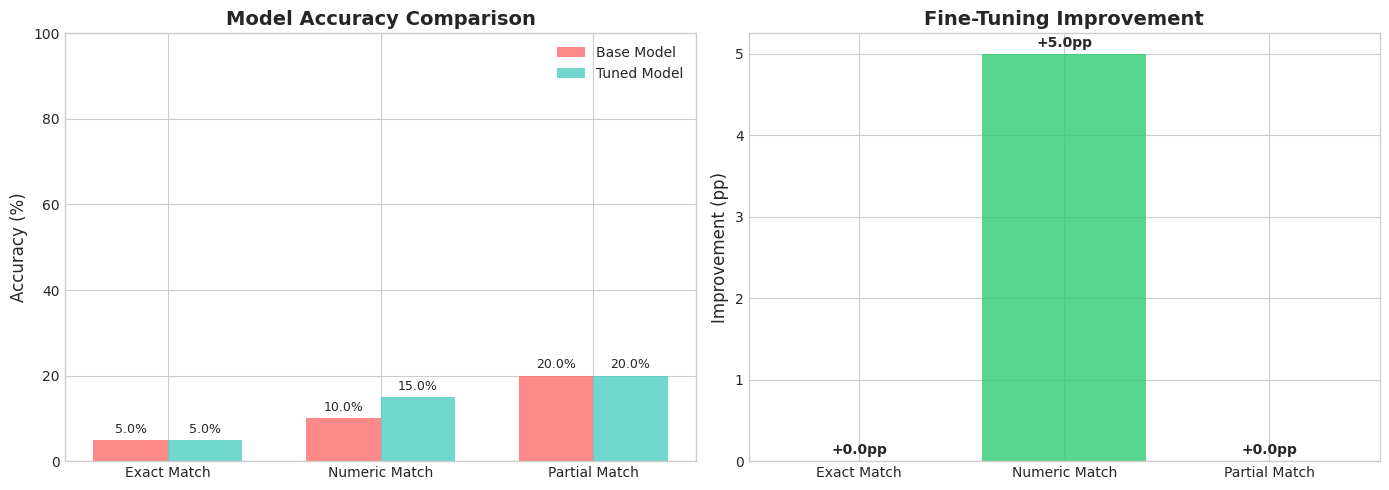

In [23]:
# ============================================================================
# VISUALIZATION
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy Comparison Bar Chart
ax1 = axes[0]
metrics = ['Exact Match', 'Numeric Match', 'Partial Match']
base_values = [base_metrics['exact_match'], base_metrics['numeric_match'], base_metrics['partial_match']]
tuned_values = [tuned_metrics['exact_match'], tuned_metrics['numeric_match'], tuned_metrics['partial_match']]

x = range(len(metrics))
width = 0.35

bars1 = ax1.bar([i - width/2 for i in x], base_values, width, label='Base Model', color='#ff6b6b', alpha=0.8)
bars2 = ax1.bar([i + width/2 for i in x], tuned_values, width, label='Tuned Model', color='#4ecdc4', alpha=0.8)

ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.set_ylim(0, 100)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

# Plot 2: Improvement Summary
ax2 = axes[1]
improvements = [tuned_metrics[m.lower().replace(' ', '_')] - base_metrics[m.lower().replace(' ', '_')] 
                for m in ['exact_match', 'numeric_match', 'partial_match']]

colors = ['#2ecc71' if imp > 0 else '#e74c3c' for imp in improvements]
bars3 = ax2.bar(metrics, improvements, color=colors, alpha=0.8)

ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_ylabel('Improvement (pp)', fontsize=12)
ax2.set_title('Fine-Tuning Improvement', fontsize=14, fontweight='bold')

# Add value labels
for bar, imp in zip(bars3, improvements):
    height = bar.get_height()
    ax2.annotate(f'{imp:+.1f}pp',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3 if height >= 0 else -15),
                textcoords="offset points",
                ha='center', va='bottom' if height >= 0 else 'top', 
                fontsize=10, fontweight='bold')

plt.tight_layout()

# Save the figure
output_path = PROJECT_ROOT / "outputs" / "financial_agent_comparison.png"
output_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(output_path, dpi=150, bbox_inches='tight')
print(f"✓ Figure saved to: {output_path}")

# Log to MLflow
with mlflow.start_run(run_name="Comparison_Visualization"):
    mlflow.log_artifact(str(output_path))
    mlflow.log_metrics({
        "base_exact_match": base_metrics['exact_match'],
        "base_numeric_match": base_metrics['numeric_match'],
        "tuned_exact_match": tuned_metrics['exact_match'],
        "tuned_numeric_match": tuned_metrics['numeric_match'],
        "improvement_exact": tuned_metrics['exact_match'] - base_metrics['exact_match'],
        "improvement_numeric": tuned_metrics['numeric_match'] - base_metrics['numeric_match'],
    })

plt.show()


## 5.5 Side-by-Side Comparison

Display detailed side-by-side comparison of base vs tuned model responses.


In [24]:
# ============================================================================
# SIDE-BY-SIDE COMPARISON
# ============================================================================

print("="*80)
print("SIDE-BY-SIDE COMPARISON: Base vs Tuned Model")
print("="*80)
print(f"Showing all {len(evaluation_sample)} evaluation examples")

for idx in range(len(evaluation_sample)):
    row = evaluation_sample.iloc[idx]
    
    print(f"\n{'='*80}")
    print(f"EXAMPLE {idx + 1}/{len(evaluation_sample)}")
    print(f"{'='*80}")
    
    # Full question (no truncation)
    print(f"\n📋 Question:\n{row['question']}")
    print(f"\n🎯 Ground Truth: {row['answer']}")
    
    print(f"\n{'─'*40}")
    print("BASE MODEL")
    print(f"{'─'*40}")
    print(f"Answer: {row.get('base_agent_answer', 'N/A')}")
    
    # Full thinking (no truncation)
    base_thinking = row.get('base_thinking', '')
    if base_thinking:
        print(f"\nReasoning:\n{base_thinking}")
    
    # Full code (no truncation)
    base_code = row.get('base_code', '')
    if base_code:
        print(f"\nCode:\n{base_code}")
    
    # Show score if available
    if 'base_answer_score' in row:
        base_code_display = row['base_code_score'] if row['base_code_score'] != "N/A" else "N/A"
        print(f"\n📊 Scores - Answer: {row['base_answer_score']}/5, "
              f"Reasoning: {row['base_reasoning_score']}/5, "
              f"Code: {base_code_display}{'/5' if base_code_display != 'N/A' else ''}")
    
    print(f"\n{'─'*40}")
    print("TUNED MODEL")
    print(f"{'─'*40}")
    print(f"Answer: {row.get('tuned_agent_answer', 'N/A')}")
    
    # Full thinking (no truncation)
    tuned_thinking = row.get('tuned_thinking', '')
    if tuned_thinking:
        print(f"\nReasoning:\n{tuned_thinking}")
    
    # Full code (no truncation)
    tuned_code = row.get('tuned_code', '')
    if tuned_code:
        print(f"\nCode:\n{tuned_code}")
    
    # Show score if available
    if 'tuned_answer_score' in row:
        tuned_code_display = row['tuned_code_score'] if row['tuned_code_score'] != "N/A" else "N/A"
        print(f"\n📊 Scores - Answer: {row['tuned_answer_score']}/5, "
              f"Reasoning: {row['tuned_reasoning_score']}/5, "
              f"Code: {tuned_code_display}{'/5' if tuned_code_display != 'N/A' else ''}")


SIDE-BY-SIDE COMPARISON: Base vs Tuned Model
Showing all 20 evaluation examples

EXAMPLE 1/20

📋 Question:
what was the percent change in net expense in interest and penalties between 2008 and 2009?

🎯 Ground Truth: -36%

────────────────────────────────────────
BASE MODEL
────────────────────────────────────────
Answer: N/A

📊 Scores - Answer: 1/5, Reasoning: 1/5, Code: N/A

────────────────────────────────────────
TUNED MODEL
────────────────────────────────────────
Answer: N/A

📊 Scores - Answer: 1/5, Reasoning: 1/5, Code: N/A

EXAMPLE 2/20

📋 Question:
what was the percentage reduction in the segment 2019s backlog from 2006 to 2007

🎯 Ground Truth: -18.8%

────────────────────────────────────────
BASE MODEL
────────────────────────────────────────
Answer: 18.75%

Code:
old_backlog = 3200000000
new_backlog = 2600000000
result = ((old_backlog - new_backlog) / old_backlog) * 100
print(f"{result}%")

📊 Scores - Answer: 4/5, Reasoning: 1/5, Code: 5/5

───────────────────────────────────

# Summary & Conclusions

## What We Built

This notebook demonstrated a complete workflow for building a **Financial Reasoning Agent** with:

### 1. **DeepSeek-R1-Distill-Qwen-7B Base Model**
- Distilled from DeepSeek's reasoning-focused R1 model
- Naturally produces chain-of-thought reasoning traces
- Strong mathematical and instruction-following capabilities

### 2. **"Thinking" Architecture**
- Model generates explicit reasoning traces in `<think>` tags
- Clear separation of thinking process from final answer
- Enables debugging and understanding of model behavior

### 3. **Tool-Augmented Computation**
- Python REPL tool for precise mathematical calculations
- Eliminates arithmetic errors common in LLM responses
- Agent learns when and how to use tools effectively

### 4. **Process Reward Model (PRM) Training**
- **Format reward (20%)**: Checks for proper `<think>` and `<answer>` tags
- **Reasoning reward (30%)**: Rewards correct intermediate calculation steps
- **Accuracy reward (50%)**: Uses normalized answer comparison for robustness
- Training uses ground truth `steps` from ConvFinQA dataset

### 5. **Comprehensive Evaluation**
- Before/after comparison with same agent structure
- LLM-as-Judge evaluation for reasoning quality
- Full MLflow tracing for observability

## MLflow Integration

All experiment data is logged to MLflow:

| Artifact | Description | View In |
|----------|-------------|---------|
| Agent Traces | Full execution paths for each question | Traces tab |
| Baseline Results | Base model answers and metrics | Artifacts |
| Tuned Results | Fine-tuned model answers and metrics | Artifacts |
| LLM-Judge Scores | Reasoning, code, answer quality scores | Evaluation tab |
| Comparison Table | Side-by-side results | Artifacts |
| Visualization | Accuracy comparison chart | Artifacts |

## Next Steps

1. **Scale Training**: Increase `MAX_TRAINING_STEPS` for better results
2. **Expand Dataset**: Add more financial reasoning examples
3. **Advanced Tools**: Add financial APIs, data retrieval tools
4. **Deploy Agent**: Export to production with MLflow Model Registry

## References

- [DeepSeek-R1 Technical Report](https://arxiv.org/abs/2401.02954) - The base reasoning model
- [ConvFinQA Dataset (with steps)](https://huggingface.co/datasets/MehdiHosseiniMoghadam/ConvFinQA) - Financial QA with reasoning traces
- [ConvFinQA Paper](https://arxiv.org/abs/2210.03849) - Original ConvFinQA research
- [Unsloth GRPO Notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
- [MLflow Tracing Documentation](https://mlflow.org/docs/latest/llms/tracing/index.html)
- [LangGraph Documentation](https://python.langchain.com/docs/langgraph)
- [Process Reward Models for LLM Reasoning](https://arxiv.org/abs/2305.20050) - PRM approach background


In [25]:
# ============================================================================
# FINAL CLEANUP & SUMMARY
# ============================================================================

print("="*80)
print("NOTEBOOK EXECUTION COMPLETE")
print("="*80)

print("\n📊 Final Summary:")
print(f"   - Base Model Exact Match: {base_metrics.get('exact_match', 0):.1f}%")
print(f"   - Tuned Model Exact Match: {tuned_metrics.get('exact_match', 0):.1f}%")
print(f"   - Improvement: {tuned_metrics.get('exact_match', 0) - base_metrics.get('exact_match', 0):+.1f}pp")

print("\n📁 Artifacts saved:")
print(f"   - Visualization: {PROJECT_ROOT / 'outputs' / 'financial_agent_comparison.png'}")
print(f"   - MLflow runs: {MLRUNS_DIR}")

print("\n🔗 View results in MLflow UI:")
print("   mlflow ui --port 5000")
print("   Open: http://localhost:5000")

print("\n✅ All phases completed successfully!")


NOTEBOOK EXECUTION COMPLETE

📊 Final Summary:
   - Base Model Exact Match: 5.0%
   - Tuned Model Exact Match: 5.0%
   - Improvement: +0.0pp

📁 Artifacts saved:
   - Visualization: /workspace/outputs/financial_agent_comparison.png
   - MLflow runs: /workspace/notebooks/agents/mlruns

🔗 View results in MLflow UI:
   mlflow ui --port 5000
   Open: http://localhost:5000

✅ All phases completed successfully!
